In [98]:
import pandas as pd
import numpy as np
import os
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib

from statannotations.Annotator import Annotator
from scipy.stats import pearsonr
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import QuantileTransformer
from combat.pycombat import pycombat
# from pycombat import pycombat
from sklearn.manifold import TSNE
from lightgbm import LGBMClassifier, LGBMRegressor
# import sci_palettes
# sci_palettes.register_cmap()
import roc_utils as ru
from matplotlib_venn import venn2, venn3
import proplot
from joblib import Parallel, delayed

import warnings
# warnings.filterwarnings("ignore", category=UserWarning)
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

plt.set_cmap('winter')
plt.rcParams.update({'font.size': 18})


from sklearn.preprocessing import scale
from scipy.linalg import eigh
from statsmodels.regression.mixed_linear_model import MixedLM
from itertools import combinations

<Figure size 400x400 with 0 Axes>

In [121]:
flow = pd.read_csv('gated_medianCorrected.csv').iloc[:, 1:]
meta = pd.read_csv('metadata.csv')

In [122]:
df = flow.merge(meta, on='Sample')

Singlets/Live cells/B cells | Median (Comp-450_50 Violet I-A)--US  \
0                                             0.440925                   
1                                             0.694943                   
2                                             0.397766                   
3                                             0.624656                   
4                                             0.697409                   
..                                                 ...                   
394                                           0.739334                   
395                                           0.034002                   
396                                           0.231298                   
397                                           0.833050                   
398                                           0.233764                   

     Singlets/Live cells/B cells | Median (Comp-515_20 Blue D-A)--US  \
0                                             0.352583                 
1                                             0.404330                 
2                                             0.972340                 
3                                             0.079408                 
4                                             0.596875                 
..                                                 ...                 
394                                           0.352583                 
395                                           0.765353                 
396                                           0.445246                 
397                                           0.962713                 
398                                           0.531891                 

     Singlets/Live cells/B cells | Median (Comp-586_15 YG E-A)--US  \
0                                             1.031154               
1                                             0.026557               
2                                             0.026557               
3                                             0.026557               
4                                             0.945812               
..                                                 ...               
394                                           0.026557               
395                                           0.026557               
396                                           0.026557               
397                                           0.940936               
398                                           0.026557               

     Singlets/Live cells/B cells | Median (Comp-610_20 YG D-A)--US  \
0                                             0.179658               
1                                             0.095052               
2                                             0.960724               
3                                             0.080338               
4                                             0.659088               
..                                                 ...               
394                                           0.600232               
395                                           0.396689               
396                                           0.524210               
397                                           0.507043               
398                                           0.877345               

     Singlets/Live cells/B cells | Median (Comp-660_20 Red C-A)--US  \
0                                             0.530765                
1                                             0.141527                
2                                             1.001694                
3                                             0.226823                
4                                             0.641289                
..                                                 ...                
394                                           0.409428                
3

In [45]:
# define function to make sure comparing Sex and age-matched when randomly drawn
def get_drop_index(df, pair, col='Group'):
    # determine which group has more cohort (the bigger one will be removed)
    bigger = [pair[0] if df.loc[df[col].isin([pair[0]]), :].shape[0] > df.loc[df[col].isin([pair[1:]]), :].shape[0] else pair[1:]]
    smaller = [i for i in pair if i!=bigger]

    # adjust age first
    small_avgAge = df.loc[(df[col].isin(smaller)), 'Age'].mean()
    big_avgAge = df.loc[(df[col].isin(bigger)), 'Age'].mean()
    drop_age = []
    if big_avgAge > small_avgAge:
        i = -1
        while big_avgAge > small_avgAge:
            drop_age += [df.loc[(df[col].isin(bigger)), :].sort_values('Age').index[i]]
            big_avgAge = df.loc[(df[col].isin(bigger)), 'Age'].drop(drop_age).mean()
            i = i-1
    else:
        i = 0
        while big_avgAge < small_avgAge:
            drop_age += [df.loc[(df[col].isin(bigger)), :].sort_values('Age').index[i]]
            big_avgAge = df.loc[(df[col].isin(bigger)), 'Age'].drop(drop_age).mean()
            i = i+1

    # get proportion of M:F
    df = df.drop(drop_age)

    small_MtoF = df.loc[df[col].isin(smaller), 'Sex'].value_counts().loc['M']/df.loc[df[col].isin(smaller), 'Sex'].value_counts().loc['F']
    big_MtoF = df.loc[df[col].isin(bigger), 'Sex'].value_counts().loc['M']/df.loc[df[col].isin(bigger), 'Sex'].value_counts().loc['F']

    if small_MtoF > big_MtoF:
        # print(small_MtoF)
        # print(big_MtoF)
        n_remove = int((small_MtoF*df.loc[df[col].isin(bigger), 'Sex'].value_counts().loc['F'] - df.loc[df[col].isin(bigger), 'Sex'].value_counts().loc['M'])/small_MtoF)
        # print(n_remove)
        return drop_age+list(np.random.choice(df.loc[(df[col].isin(bigger)) & (df.Sex=='F'), :].index, n_remove, replace=False))
    else:
        n_remove = int(df.loc[df[col].isin(bigger), 'Sex'].value_counts().loc['M'] - small_MtoF*df.loc[df[col].isin(bigger), 'Sex'].value_counts().loc['F'])
        return drop_age+list(np.random.choice(df.loc[(df[col].isin(bigger)) & (df.Sex=='M'), :].index, n_remove, replace=False))

# looking at batch effects

In [16]:
from scipy.stats import spearmanr, pearsonr

df['Group_PD'] = df['Group'].apply(lambda x: 1 if x in ['LBD', 'PD', 'PD_MCIDEM'] else 0)#.head(40)
test_idx = np.random.choice(df.shape[0], 100, replace=False)
train_idx = [i for i in range(df.shape[0]) if i not in test_idx]
model = LGBMClassifier(n_jobs=-1, class_weight='balanced')
df_train = df.iloc[train_idx, :]
df_test = df.iloc[test_idx, :]

model.fit(df_train.loc[:, imm_feat], df_train['Group_PD'])
df_one_hot = pd.get_dummies(df_test['Batch'], prefix='Batch').applymap(lambda x: 1 if x else 0)
np.mean([roc_auc_score(df_one_hot.iloc[:, i], model.predict(df_test.loc[:, imm_feat])) for i in range(df_one_hot.shape[1])])
# roc_auc_score(df_test.Group_PD, model.predict(df_test.loc[:, imm_feat]))
# roc_auc_score(df_test['Batch--'], model.predict(df_test.loc[:, imm_feat]))
# spearmanr(df_test['Site'],model.predict(df_test.loc[:, imm_feat]))

0.48105316594226416

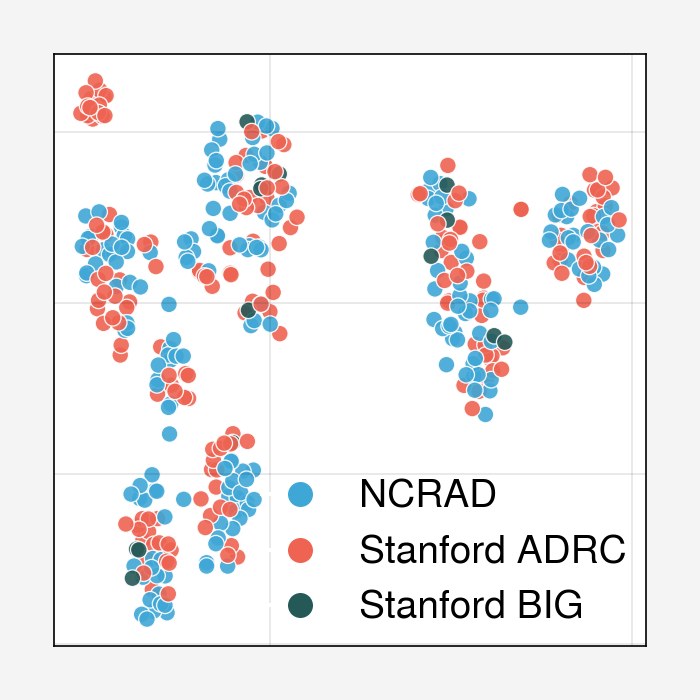

In [154]:
colors = ['#255957', "#EE6352", '#3FA7D6', "#FAC05E", "#59CD90"]

reducer = TSNE(random_state=11)
xy = reducer.fit_transform(df.loc[:, imm_feat])

fig, ax = plt.subplots(1, figsize=(3.5,3.5))
sns.scatterplot(x=xy[:, 0], y=xy[:, 1], color=df.Site.apply(lambda x: colors[1] if x=='Stanford' else colors[2] if x=='NCRAD' else colors[0]), alpha=0.9)

custom_lines = [Line2D([0], [0], marker='o', color='White', label='Scatter', markerfacecolor=colors[2], markersize=10),
                Line2D([0], [0], marker='o', color='White', label='Scatter', markerfacecolor=colors[1], markersize=10),
                Line2D([0], [0], marker='o', color='White', label='Scatter', markerfacecolor=colors[0], markersize=10)]
plt.legend(custom_lines, ['NCRAD', 'Stanford ADRC', 'Stanford BIG'], loc='lower right', prop={'size': 14}, frameon=False)

# x-label as blank
plt.tick_params(
    # axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

plt.tight_layout()
plt.savefig('../figures/manuscript_scatter_tsneSite.svg', transparent=True)

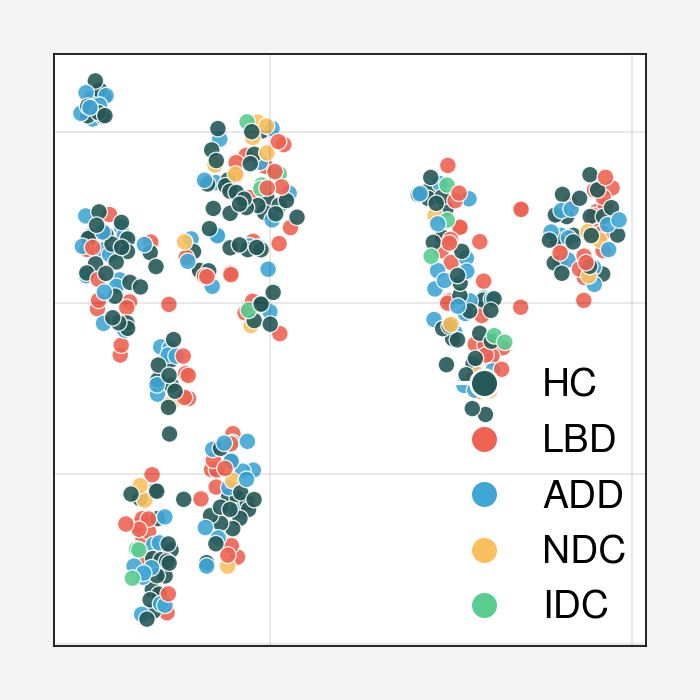

In [155]:
colors = ['#255957', "#EE6352", '#3FA7D6', "#FAC05E", "#59CD90"]

reducer = TSNE(random_state=11)
xy = reducer.fit_transform(df.loc[:, imm_feat])

fig, ax = plt.subplots(1, figsize=(3.5,3.5))
sns.scatterplot(x=xy[:, 0], y=xy[:, 1], color=df.Group.apply(lambda x: colors[2] if x=='AD' else colors[0] if x=='HC' else colors[4] if x=='IDCO' else colors[3] if x=='NDC' else colors[1]), alpha=0.9)

custom_lines = [Line2D([0], [0], marker='o', color='White', label='Scatter', markerfacecolor=colors[0], markersize=10),
                Line2D([0], [0], marker='o', color='White', label='Scatter', markerfacecolor=colors[1], markersize=10),
                Line2D([0], [0], marker='o', color='White', label='Scatter', markerfacecolor=colors[2], markersize=10),
                Line2D([0], [0], marker='o', color='White', label='Scatter', markerfacecolor=colors[3], markersize=10),
                Line2D([0], [0], marker='o', color='White', label='Scatter', markerfacecolor=colors[4], markersize=10)]
plt.legend(custom_lines, ['HC', 'LBD', 'ADD', 'NDC', 'IDC'], loc='lower right', prop={'size': 14}, frameon=False)

# x-label as blank
plt.tick_params(
    # axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off

plt.tight_layout()
plt.savefig('../figures/manuscript_scatter_tsneGroup.svg', transparent=True)

# Investigate comor

In [269]:
comor_sub = ['DIABET', 'SLEEPAP', 'REMDIS', 'HYPERT', 'VB12DEF', 
              'HYPCHOL', 'ARTH'] #NACCTBI <- left out cos of only 1 case

pair = ['HC', 'PD', 'PD_MCIDEM','LBD']
n_iters = 5
preds = {c:np.nan for c in comor_sub}
y_true = {c:np.nan for c in comor_sub}
for i, comor in enumerate(comor_sub):
    X = df.loc[:, imm_feat].loc[df.Group.isin(pair), :]
    X_IDCO = df.loc[:, imm_feat].loc[df.Group=='IDCO', :]
    y = df.loc[df.Group.isin(pair), 'Group'].apply(lambda x: 0 if x in [pair[0]] else 1)
    y_IDCO = df.loc[df.Group=='IDCO', 'Group'].apply(lambda x: 0 if x in ['IDCO'] else 1)
    
    X_train_HC, X_test_HC, y_train_HC, y_test_HC = train_test_split(X, y, stratify=y, random_state=i*2)
    X_train_IDCO, X_test_IDCO, y_train_IDCO, y_test_IDCO = train_test_split(X_IDCO, y_IDCO, random_state=i*2)
    X_train, X_test = pd.concat([X_train_HC, X_train_IDCO], axis=0), pd.concat([X_test_HC, X_test_IDCO], axis=0)
    y_train, y_test = pd.concat([y_train_HC, y_train_IDCO], axis=0), pd.concat([y_test_HC, y_test_IDCO], axis=0)
    
    train_idx, test_idx = X_train.index, X_test.index
    X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
    df_test = df.loc[test_idx, :]
    
        
    model = LGBMClassifier(n_jobs=-1, class_weight='balanced', n_estimators =500, learning_rate=0.06)
    model.fit(X_train, y_train.values)
    df_test = df_test.loc[~df_test[comor].isna(), :]
    drop_indices = get_drop_index(df_test.loc[~df_test[comor].isna(), :], [0, 1],  col=comor)
    df_test = df_test.drop(drop_indices)
    X_test, y_test = df_test.loc[:, imm_feat], df_test[comor].apply(lambda x: 0 if x==0 else 1)
    if y_test.nunique()==1:
        continue
    preds[comor] = model.predict_proba(X_test)[:, 1]
    y_true[comor] = y_test
    # X_test_hc, y_test_hc = X_test[np.where(hc_cond)[0], :], y_test.iloc[np.where(hc_cond)[0]]
    pred_hc = preds[comor]
    print(comor)
    print(df[comor].dropna().apply(lambda x: 0 if x==0 else 1).value_counts())
    print(roc_auc_score(y_test, pred_hc))
    print(average_precision_score(y_test, pred_hc))
    print('----')

DIABET
DIABET
0    269
1     15
Name: count, dtype: int64
0.3137254901960784
0.027777777777777776
----
SLEEPAP
SLEEPAP
0    177
1     40
Name: count, dtype: int64
0.4703703703703703
0.23940915714371097
----
REMDIS
REMDIS
0    192
1     26
Name: count, dtype: int64
0.8021978021978021
0.5280952380952381
----
HYPERT
HYPERT
0    189
1     95
Name: count, dtype: int64
0.5071428571428571
0.37212376038595546
----
VB12DEF
VB12DEF
0    257
1     21
Name: count, dtype: int64
0.5277777777777777
0.11571628651460585
----
HYPCHOL
HYPCHOL
0    159
1    125
Name: count, dtype: int64
0.4973544973544973
0.6082160000674581
----
ARTH
ARTH
0    124
1     95
Name: count, dtype: int64
0.6375
0.7683644356516781
----


/home/tpjoe/miniconda3/envs/main/lib/python3.10/site-packages/roc_utils/_roc.py:563: UserWarning: Not all classes are represented in current bootstrap sample. Skipping it. If this problem occurs too often, try stratified=True or operate with larger samples.
  warnings.warn(msg)
/home/tpjoe/miniconda3/envs/main/lib/python3.10/site-packages/roc_utils/_roc.py:563: UserWarning: Not all classes are represented in current bootstrap sample. Skipping it. If this problem occurs too often, try stratified=True or operate with larger samples.
  warnings.warn(msg)


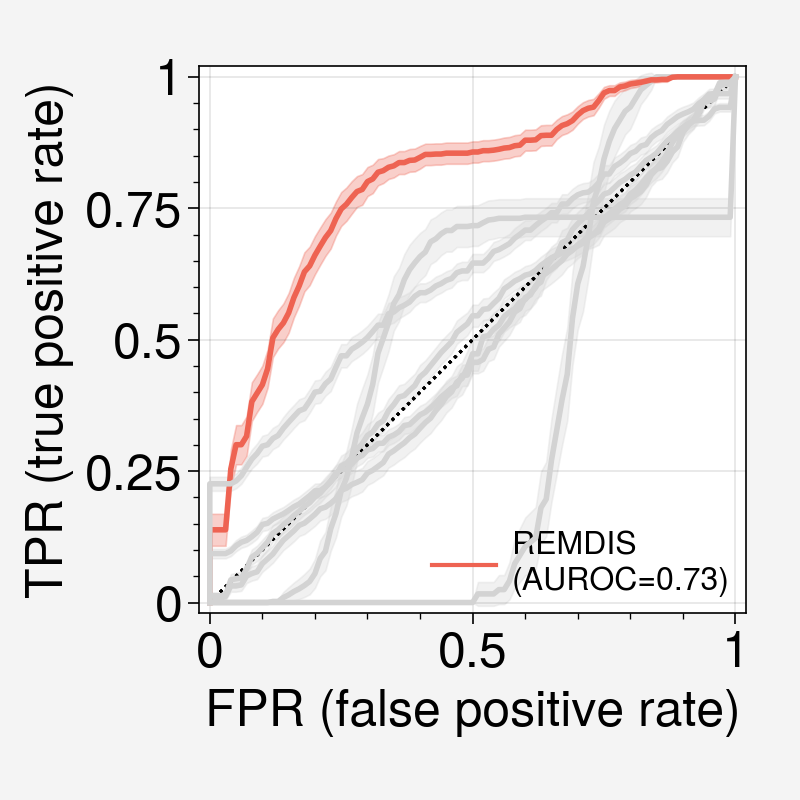

In [270]:
colors = ['#255957', "#EE6352", '#3FA7D6', "#FAC05E", "#EE6352"]

fig, ax = plt.subplots(1, figsize=(4,4))

for ii, i in enumerate(list(preds.keys())):
    plt_df = pd.DataFrame([preds[i], y_true[i]], index=['value', 'Group']).transpose()
    plt_df.Group = plt_df.Group.apply(lambda x: True if x==1 else False)
    # plt_df = plt_df.melt('Group').dropna()
    
    x, y = plt_df.value, plt_df.Group
    if i in ['REMDIS']:
        # Compute the ROC curve...
        pos_label = True
        n_samples = 200
        rocs = ru.compute_roc_bootstrap(X=x, y=y, pos_label=pos_label,
                                     n_bootstrap=n_samples,
                                     random_state=42,
                                     return_mean=False)
        ru.plot_mean_roc(rocs, show_ci=True, show_ti=False, color=colors[4], linewidth=2)
    else:
        pos_label = True
        n_samples = 200
        rocs = ru.compute_roc_bootstrap(X=x, y=y, pos_label=pos_label,
                                     n_bootstrap=n_samples,
                                     random_state=42,
                                     return_mean=False)
        ru.plot_mean_roc(rocs, show_ci=True, show_ti=False, color='lightgray', linewidth=2)


custom_lines = [Line2D([0], [0], color=colors[4], label='Scatter', markerfacecolor=colors[2], markersize=4)]
plt.legend(custom_lines, ['REMDIS\n(AUROC=0.73)'], loc='lower right', prop={'size': 11.5}, frameon=False)
plt.tight_layout()
plt.savefig('../figures/auc_comorbid_new.svg', transparent=True)
# plt.show()

# Predicting Main Groups

In [26]:
pairs = [['HC', 'AD'], ['HC', 'PD', 'PD_MCIDEM','LBD']]#, ['AD', 'PD', 'PD_MCIDEM','LBD'], ['IDCO', 'PD', 'PD_MCIDEM','LBD']]
transfer_pairs = [['AD', 'PD', 'PD_MCIDEM','LBD'], ['NDC', 'PD', 'PD_MCIDEM','LBD'], ['IDC', 'PD', 'PD_MCIDEM','LBD']]
# pairs = [['HC','LBD'], ['HC','PD_MCIDEM'], ['HC','PD'], ['AD','LBD'], ['AD','PD_MCIDEM'], ['AD','PD'], ['PD','LBD'], ['PD','PD_MCIDEM'], ['PD_MCIDEM','LBD']]
n_iters = 10
aucs_hc = {'-'.join(p):[] for p in pairs}
aucs_idc = {'-'.join(p):[] for p in pairs}
aucs_male = {'-'.join(p):[] for p in pairs}
aucs_female = {'-'.join(p):[] for p in pairs}
aucs_noe4 = {'-'.join(p):[] for p in pairs}
aucs_e4 = {'-'.join(p):[] for p in pairs}
aucs_pd = {'-'.join(p):[] for p in transfer_pairs}
aucs_stanford = {'-'.join(p):[] for p in pairs}
aucs_ncrad = {'-'.join(p):[] for p in pairs}
auprcs_hc = {'-'.join(p):[] for p in pairs}
auprcs_idc = {'-'.join(p):[] for p in pairs}
auprcs_male = {'-'.join(p):[] for p in pairs}
auprcs_female = {'-'.join(p):[] for p in pairs}
auprcs_e4 = {'-'.join(p):[] for p in pairs}
auprcs_noe4 = {'-'.join(p):[] for p in pairs}
auprcs_pd = {'-'.join(p):[] for p in transfer_pairs}
auprcs_stanford = {'-'.join(p):[] for p in pairs}
auprcs_ncrad = {'-'.join(p):[] for p in pairs}
prevalences_hc = {'-'.join(p):[] for p in pairs}
prevalences_idc = {'-'.join(p):[] for p in pairs}
prevalences_male = {'-'.join(p):[] for p in pairs}
prevalences_female = {'-'.join(p):[] for p in pairs}
prevalences_e4 = {'-'.join(p):[] for p in pairs}
prevalences_noe4 = {'-'.join(p):[] for p in pairs}
prevalences_pd = {'-'.join(p):[] for p in transfer_pairs}
prevalences_stanford = {'-'.join(p):[] for p in pairs}
prevalences_ncrad = {'-'.join(p):[] for p in pairs}
preds = pd.DataFrame(np.full([df.shape[0], n_iters], np.nan), index=df.index)
residuals = pd.DataFrame(np.full([df.shape[0], n_iters], np.nan), index=df.index)
wts = {'-'.join(p):np.zeros((n_iters, df.loc[:, imm_feat].loc[df.Group.isin(p), :].shape[1])) for p in pairs}

df = df.loc[df.Site!='NCRAD', :]

for pair in pairs:
    print(pair)
    X = df.loc[:, imm_feat].loc[df.Group.isin(pair), :]
    X_IDCO = df.loc[:, imm_feat].loc[df.Group=='IDCO', :]
    # X = X.loc[:, [i for i in X.columns if 'Freq' in i[0]]]

    y = df.loc[df.Group.isin(pair), 'Group'].apply(lambda x: 0 if x in [pair[0]] else 1)
    y_IDCO = df.loc[df.Group=='IDCO', 'Group'].apply(lambda x: 0 if x in ['IDCO'] else 1)

    # if pair!=['HC','AD']:
    #     drop_indices = get_drop_index(df, pair)
    #     X = X.drop(drop_indices)
    #     y = y.drop(drop_indices)
    #     print(X.shape[0])

    # X = preprocessing.quantile_transform(X)

    for i in range(n_iters):
        X_train_HC, X_test_HC, y_train_HC, y_test_HC = train_test_split(X, y, stratify=y, random_state=i*2)
        X_train_IDCO, X_test_IDCO, y_train_IDCO, y_test_IDCO = train_test_split(X_IDCO, y_IDCO, random_state=i*2)
        X_train, X_test = pd.concat([X_train_HC, X_train_IDCO], axis=0), pd.concat([X_test_HC, X_test_IDCO], axis=0)
        y_train, y_test = pd.concat([y_train_HC, y_train_IDCO], axis=0), pd.concat([y_test_HC, y_test_IDCO], axis=0)
        train_idx, test_idx = X_train.index, X_test.index
        X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
        df_test = df.loc[test_idx, :]
        # transformer = QuantileTransformer(n_quantiles=X_train.shape[0])
        # X_train = transformer.fit_transform(X_train)
        # X_test = transformer.transform(X_test)
        
        if pair!= ['IDCO','NDC']:
            # model = RandomForestClassifier(n_jobs=-1)#, class_weight='balanced_subsample', criterion='entropy')
            model = LGBMClassifier(n_jobs=-1, class_weight='balanced')#, n_estimators =500, learning_rate=0.06)
            # model = LogisticRegression(max_iter=10000, class_weight='balanced', penalty='elasticnet', solver='saga', l1_ratio=1, n_jobs=-1)
            # model = SVC(probability=True, kernel='linear', C=500)
            model.fit(X_train, y_train.values)
            hc_cond = df_test.Group.isin(['HC'] + pair[1:])
            idc_cond = df_test.Group.isin(['IDCO'] + pair[1:])
            X_test_hc, y_test_hc = X_test[np.where(hc_cond)[0], :], y_test.iloc[np.where(hc_cond)[0]]
            X_test_idc, y_test_idc = X_test[np.where(idc_cond)[0], :], y_test.iloc[np.where(idc_cond)[0]]
            
            pred_hc = model.predict_proba(X_test_hc)[:, 1]
            preds.loc[df_test.loc[hc_cond, :].index, i] = pred_hc
            residuals.loc[df_test.loc[hc_cond, :].index, i] = np.abs(y_test_hc-pred_hc)
            pred_idc = model.predict_proba(X_test_idc)[:, 1]
            preds.loc[df_test.loc[idc_cond, :].index, i] = pred_idc
            residuals.loc[df_test.loc[idc_cond, :].index, i] = np.abs(y_test_idc-pred_idc)
            
            wts['-'.join(pair)][i, :] = model.feature_importances_
            # import shap
            # explainer = shap.TreeExplainer(model)
            # shap_values = explainer.shap_values(np.concatenate((X_train, X_test_hc, X_test_idc), axis=0))
            # wts['-'.join(pair)][i, :] = np.abs(shap_values[1]).mean(axis=0)
            
        else:
            pass
            # model = pd.read_csv('../results/LogisticRegression_wt_MainGroup.csv')
            # wt = model['HC-PD-PD_MCIDEM-LBD']
            # result = (np.dot(X_test, np.array(wt)))
            # pred = np.exp(result)/(1+np.exp(result))

        
        
        auc = roc_auc_score(y_test_hc, pred_hc)
        aucs_hc['-'.join(pair)] += [auc]
        auprc = average_precision_score(y_test_hc, pred_hc)
        auprcs_hc['-'.join(pair)] += [auprc]
        prevalence = (y_test_hc==1).sum()/len(y_test_hc)
        prevalences_hc['-'.join(pair)] += [prevalence]
        
    
        # predict stratified or transfer        
        # predict male/female
        X_sel, y_sel = X_test[np.where(df_test.Sex == 'M')[0], :], y_test.iloc[np.where(df_test.Sex == 'M')[0]]
        pred = model.predict_proba(X_sel)[:, 1]
        auc = roc_auc_score(y_sel, pred)
        aucs_male['-'.join(pair)] += [auc]
        auprc = average_precision_score(y_sel, pred)
        auprcs_male['-'.join(pair)] += [auprc]
        prevalence = (y_sel==1).sum()/len(y_sel)
        prevalences_male['-'.join(pair)] += [prevalence]

        X_sel, y_sel = X_test[np.where(df_test.Sex == 'F')[0], :], y_test.iloc[np.where(df_test.Sex == 'F')[0]]
        pred = model.predict_proba(X_sel)[:, 1]
        auc = roc_auc_score(y_sel, pred)
        aucs_female['-'.join(pair)] += [auc]
        auprc = average_precision_score(y_sel, pred)
        auprcs_female['-'.join(pair)] += [auprc]
        prevalence = (y_sel==1).sum()/len(y_sel)
        prevalences_female['-'.join(pair)] += [prevalence]

        # predict APOE/no APOEe4
        X_sel, y_sel = X_test[np.where(( ((df_test.NACCAPOE.isin([2,4,5])) & (~df_test.NACCAPOE.isna()) & (df_test.Group!='HC')) | (df_test.Group=='HC') ))[0], :], \
                       y_test.iloc[np.where(( ((df_test.NACCAPOE.isin([2,4,5])) & (~df_test.NACCAPOE.isna()) & (df_test.Group!='HC')) | (df_test.Group=='HC') ))[0]]
        pred = model.predict_proba(X_sel)[:, 1]
        auc = roc_auc_score(y_sel, pred)
        aucs_e4['-'.join(pair)] += [auc]
        auprc = average_precision_score(y_sel, pred)
        auprcs_e4['-'.join(pair)] += [auprc]
        prevalence = (y_sel==1).sum()/len(y_sel)
        prevalences_e4['-'.join(pair)] += [prevalence]

        X_sel, y_sel = X_test[np.where(( ((~df_test.NACCAPOE.isin([2,4,5])) & (~df_test.NACCAPOE.isna()) & (df_test.Group!='HC')) | (df_test.Group=='HC') ))[0], :], \
                       y_test.iloc[np.where(( ((~df_test.NACCAPOE.isin([2,4,5])) & (~df_test.NACCAPOE.isna()) & (df_test.Group!='HC')) | (df_test.Group=='HC') ))[0]]
        pred = model.predict_proba(X_sel)[:, 1]
        auc = roc_auc_score(y_sel, pred)
        aucs_noe4['-'.join(pair)] += [auc]
        auprc = average_precision_score(y_sel, pred)
        auprcs_noe4['-'.join(pair)] += [auprc]
        prevalence = (y_sel==1).sum()/len(y_sel)
        prevalences_noe4['-'.join(pair)] += [prevalence]

        # predict Stanford vs non
        X_sel, y_sel = X_test[np.where(df_test.Site == 'Stanford')[0], :], y_test.iloc[np.where(df_test.Site == 'Stanford')[0]]
        pred = model.predict_proba(X_sel)[:, 1]
        auc = roc_auc_score(y_sel, pred)
        aucs_stanford['-'.join(pair)] += [auc]
        auprc = average_precision_score(y_sel, pred)
        auprcs_stanford['-'.join(pair)] += [auprc]
        prevalence = (y_sel==1).sum()/len(y_sel)
        prevalences_stanford['-'.join(pair)] += [prevalence]

        X_sel, y_sel = X_test[np.where(df_test.Site != 'Stanford')[0], :], y_test.iloc[np.where(df_test.Site != 'Stanford')[0]]
        pred = model.predict_proba(X_sel)[:, 1]
        auc = roc_auc_score(y_sel, pred)
        aucs_ncrad['-'.join(pair)] += [auc]
        auprc = average_precision_score(y_sel, pred)
        auprcs_ncrad['-'.join(pair)] += [auprc]
        prevalence = (y_sel==1).sum()/len(y_sel)
        prevalences_ncrad['-'.join(pair)] += [prevalence]

        if pair == ['HC', 'PD', 'PD_MCIDEM','LBD']:
            # predict AD vs PD
            condition = ( (df.Group==transfer_pairs[0][0]) | ( df.index.isin(test_idx) & df.Group.isin(['PD', 'PD_MCIDEM','LBD']) ) )
            X_sel = (df.loc[:, imm_feat].loc[condition, :]).to_numpy()
            y_sel = df.loc[condition, 'Group'].apply(lambda x: 0 if x=='AD' else 1)
            pred = model.predict_proba(X_sel)[:, 1]
            preds.loc[df.loc[condition, :].index, i] = pred
            auc = roc_auc_score(y_sel, pred)
            aucs_pd['-'.join(transfer_pairs[0])] += [auc]
            auprc = average_precision_score(y_sel, pred)
            auprcs_pd['-'.join(transfer_pairs[0])] += [auprc]
            prevalence = (y_sel==1).sum()/len(y_sel)
            prevalences_pd['-'.join(transfer_pairs[0])] += [prevalence]
    
            # # predict PD vs IDCO
            auc = roc_auc_score(y_test_idc, pred_idc)
            aucs_pd['-'.join(transfer_pairs[2])] += [auc]
            auprc = average_precision_score(y_test_idc, pred_idc)
            auprcs_pd['-'.join(transfer_pairs[2])] += [auprc]
            prevalence = (y_test_idc==1).sum()/len(y_test_idc)
            prevalences_pd['-'.join(transfer_pairs[2])] += [prevalence]
            
            # predict PD vs NDC
            condition = ( (df.Group==transfer_pairs[1][0]) | ( df.index.isin(test_idx) & df.Group.isin(['PD', 'PD_MCIDEM','LBD']) ) )
            X_sel = (df.loc[:, imm_feat].loc[condition, :]).to_numpy()
            y_sel = df.loc[condition, 'Group'].apply(lambda x: 0 if x=='NDC' else 1)
            pred = model.predict_proba(X_sel)[:, 1]
            preds.loc[df.loc[condition, :].index, i] = pred
            auc = roc_auc_score(y_sel, pred)
            aucs_pd['-'.join(transfer_pairs[1])] += [auc]
            auprc = average_precision_score(y_sel, pred)
            auprcs_pd['-'.join(transfer_pairs[1])] += [auprc]
            prevalence = (y_sel==1).sum()/len(y_sel)
            prevalences_pd['-'.join(transfer_pairs[1])] += [prevalence]
            
        
        # print(auc)
    if pair!= ['IDCO','NDC']:
        wts['-'.join(pair)] = wts['-'.join(pair)].mean(axis=0)

# for cross-site
pair = ['HC', 'PD', 'PD_MCIDEM','LBD']
X = df.loc[:, imm_feat].loc[df.Group.isin(pair), :]
y = df.loc[df.Group.isin(pair), 'Group'].apply(lambda x: 0 if x==pair[0] else 1)

X_train, X_test, y_train, y_test = X.loc[df.Site=='Stanford', :], X.loc[df.Site!='Stanford', :], y.loc[df.Site=='Stanford'], y.loc[df.Site!='Stanford']
train_idx, test_idx = X_train.index, X_test.index
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# aucs_hc['-'.join(pair)+'cross-site'] = []
# auprcs_hc['-'.join(pair)+'cross-site'] = []
# prevalences_hc['-'.join(pair)+'cross-site'] = []
for i in range(n_iters):
    # model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', criterion='entropy')
    model = LGBMClassifier(n_jobs=-1, class_weight='balanced', n_estimators=500, learning_rate=0.06)
    model.fit(X_train, y_train.values)
    pred = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, pred)
    # aucs_hc['-'.join(pair)+'cross-site'] += [auc]
    auprc = average_precision_score(y_test, pred)
    # auprcs_hc['-'.join(pair)+'cross-site'] += [auprc]
    prevalence = (y_test==1).sum()/len(y_test)
    # prevalences_hc['-'.join(pair)+'cross-site'] += [prevalence]
    y_test_site = y_test
    pred_site = pred


aucs_hc = pd.DataFrame(aucs_hc)
auprcs_hc = pd.DataFrame(auprcs_hc)
prevalences_hc = pd.DataFrame(prevalences_hc)

aucs_idc = pd.DataFrame(aucs_idc)
auprcs_idc = pd.DataFrame(auprcs_idc)
prevalences_idc = pd.DataFrame(prevalences_idc)

aucs_male = pd.DataFrame(aucs_male)
aucs_female = pd.DataFrame(aucs_female)
aucs_noe4 = pd.DataFrame(aucs_noe4)
aucs_e4 = pd.DataFrame(aucs_e4)
aucs_pd = pd.DataFrame(aucs_pd)
aucs_stanford = pd.DataFrame(aucs_stanford)
aucs_ncrad = pd.DataFrame(aucs_ncrad)
auprcs_male = pd.DataFrame(auprcs_male)
auprcs_female = pd.DataFrame(auprcs_female)
auprcs_e4 = pd.DataFrame(auprcs_e4)
auprcs_noe4 = pd.DataFrame(auprcs_noe4)
auprcs_pd = pd.DataFrame(auprcs_pd)
auprcs_stanford = pd.DataFrame(auprcs_stanford)
auprcs_ncrad = pd.DataFrame(auprcs_ncrad)
prevalences_male = pd.DataFrame(prevalences_male)
prevalences_female = pd.DataFrame(prevalences_female)
prevalences_e4 = pd.DataFrame(prevalences_e4)
prevalences_noe4 = pd.DataFrame(prevalences_noe4)
prevalences_pd = pd.DataFrame(prevalences_pd)
prevalences_stanford = pd.DataFrame(prevalences_stanford)
prevalences_ncrad = pd.DataFrame(prevalences_ncrad)

# wts = pd.DataFrame(wts, index=X.columns)
# wts.to_csv('../results/LGBM_wt_MainGroup.csv')
# wts.to_csv('../results/LogisticRegression_wt_PDLBDGroup.csv')

['HC', 'AD']
['HC', 'PD', 'PD_MCIDEM', 'LBD']


## Model Reduction

In [105]:
topns = 250
aucs_feat = []
n_iters = 10
pair = ['HC', 'PD', 'PD_MCIDEM','LBD']

def bootstrap_reduction(n_feat, topfeat, X_train, y_train, df_test, X_test, y_test):
    feat = topfeat[0:(n_feat+1)]
    model2 = LGBMClassifier(n_jobs=-1, class_weight='balanced', n_estimators =500, learning_rate=0.06)
    model2.fit(X_train.loc[:, feat], y_train.values)
    hc_cond = df_test.Group.isin(['HC'] + pair[1:])
    idc_cond = df_test.Group.isin(['IDCO'] + pair[1:])
    X_test_hc, y_test_hc = X_test.iloc[np.where(hc_cond)[0], :].loc[:, feat], y_test.iloc[np.where(hc_cond)[0]]
    pred_hc = model2.predict_proba(X_test_hc)[:, 1]
    X_test_idc, y_test_idc = X_test.iloc[np.where(idc_cond)[0], :].loc[:, feat], y_test.iloc[np.where(idc_cond)[0]]
    pred_idc = model2.predict_proba(X_test_idc)[:, 1]    
    return np.mean([roc_auc_score(y_test_hc, pred_hc), roc_auc_score(y_test_idc, pred_idc)])


for i in range(n_iters):
    X = df.loc[:, imm_feat].loc[df.Group.isin(pair), :]
    X_IDCO = df.loc[:, imm_feat].loc[df.Group=='IDCO', :]
    y = df.loc[df.Group.isin(pair), 'Group'].apply(lambda x: 0 if x in [pair[0]] else 1)
    y_IDCO = df.loc[df.Group=='IDCO', 'Group'].apply(lambda x: 0 if x in ['IDCO'] else 1)
    
    X_train_HC, X_test_HC, y_train_HC, y_test_HC = train_test_split(X, y, stratify=y, random_state=i*2)
    X_train_IDCO, X_test_IDCO, y_train_IDCO, y_test_IDCO = train_test_split(X_IDCO, y_IDCO, random_state=i*2)
    X_train, X_test = pd.concat([X_train_HC, X_train_IDCO], axis=0), pd.concat([X_test_HC, X_test_IDCO], axis=0)
    y_train, y_test = pd.concat([y_train_HC, y_train_IDCO], axis=0), pd.concat([y_test_HC, y_test_IDCO], axis=0)
    train_idx, test_idx = X_train.index, X_test.index
    df_test = df.loc[test_idx, :]
    
    model = LGBMClassifier(n_jobs=-1, class_weight='balanced', n_estimators =500, learning_rate=0.06)
    model.fit(X_train, y_train.values)
    topfeat = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).index
    auc_top = []
    aucs_feat += [(Parallel(n_jobs=topns)(delayed(bootstrap_reduction)(n_feat, topfeat, X_train, y_train, df_test, X_test, y_test) \
                             for n_feat in range(topns)))]

/tmp/ipykernel_480472/3181551868.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels[1:-2]+[labels[-1]])


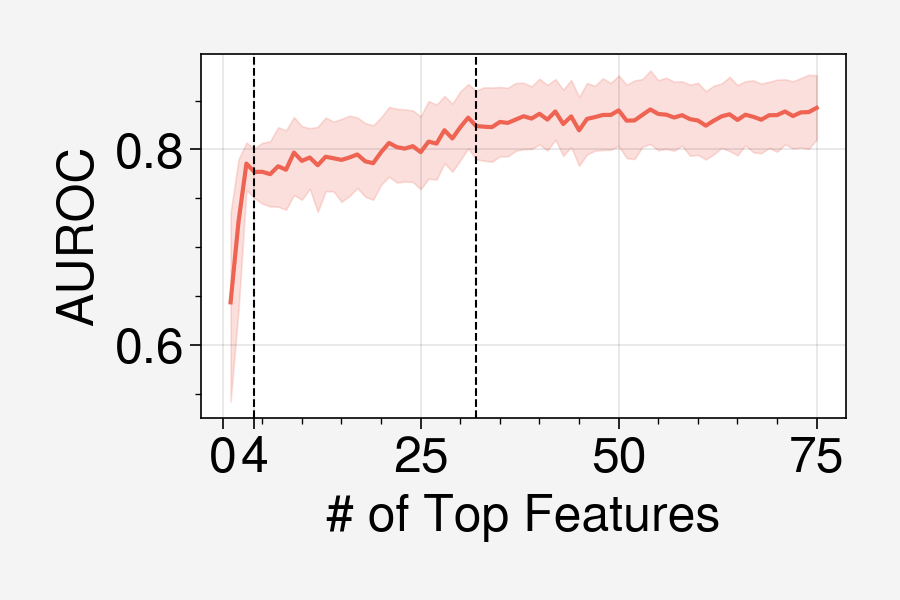

In [24]:
plt_df = pd.DataFrame(aucs_feat).melt()
plt_df.variable = plt_df.variable+1
plt_df = plt_df.loc[plt_df.variable<=75, :]

fig, ax = plt.subplots(1, figsize=(4.5, 3))
ax = sns.lineplot(data=plt_df, x='variable', y='value', color='#EE6352')
plt.axvline(4, color='black', linestyle='--', lw=0.75)
plt.axvline(32, color='black', linestyle='--', lw=0.75)

labels = [w.get_text() for w in ax.get_xticklabels()]
locs=list(ax.get_xticks())
labels+=['4']
# labels+=['10']
locs+=[4]
# locs+=[10]

ax.set_xticklabels(labels[1:-2]+[labels[-1]])
ax.set_xticks(locs[1:-2]+[locs[-1]])

plt.ylabel('AUROC')
plt.xlabel('# of Top Features')
plt.tight_layout()

plt.savefig('../figures/top_n.svg', transparent=True)

## Model Residuals

In [314]:
plt_df = pd.concat([df[['Sex', 'Age', 'NACCAPOE', 'Site', 'leva_dose', 'NACCUDSD', 'Group']], pd.DataFrame(residuals.mean(axis=1), columns=['res'])], axis=1)
plt_df = plt_df.loc[~plt_df.res.isna(), :]
plt_df = plt_df.loc[plt_df.Group.isin(['PD', 'PD_MCIDEM', 'LBD', 'HC']), :]
res_by = []
res_by += [(stats.mannwhitneyu(plt_df.loc[plt_df.Sex=='M', 'res'], plt_df.loc[plt_df.Sex=='F', 'res']))[1]]

plt_df_noNA = plt_df.loc[~plt_df.Age.isna(), :]
res_by += [(pearsonr(plt_df_noNA.loc[:, 'res'], plt_df_noNA.loc[:, 'Age']))[1]]

plt_df_noNA = plt_df.loc[~plt_df.leva_dose.isna(), :]
res_by += [(pearsonr(plt_df_noNA.loc[:, 'res'], plt_df_noNA.loc[:, 'leva_dose']))[1]]

# plt_df_noNA = plt_df.loc[~plt_df.Site.isna(), :]
# res_by += [(stats.mannwhitneyu(plt_df_noNA.loc[(~plt_df_noNA.Group.isin(['AD', 'PDD', 'NDC', 'IDCO'])) & (plt_df_noNA.Site=='Stanford'), 'res'], 
#                                plt_df_noNA.loc[(~plt_df_noNA.Group.isin(['AD', 'PDD', 'NDC', 'IDCO'])) & (plt_df_noNA.Site!='Stanford'), 'res']))[1]]

plt_df_noNA = plt_df.loc[~plt_df.NACCAPOE.isna(), :]
res_by += [(stats.mannwhitneyu(plt_df_noNA.loc[plt_df_noNA.NACCAPOE.isin([2,4,5]), 'res'], plt_df_noNA.loc[~plt_df_noNA.NACCAPOE.isin([2,4,5]), 'res']))[1]]

plt_df_noNA = plt_df.loc[~plt_df.Group.isna(), :]
res_by += [(stats.mannwhitneyu(plt_df_noNA.loc[plt_df_noNA.Group.isin(['LBD']), 'res'], plt_df_noNA.loc[~plt_df_noNA.Group.isin(['PD_MCIDEM', 'PD']), 'res']))[1]]

plt_df_noNA = plt_df.loc[~plt_df.Group.isna(), :]
res_by += [(stats.mannwhitneyu(plt_df_noNA.loc[plt_df_noNA.Group.isin(['PD']), 'res'], plt_df_noNA.loc[~plt_df_noNA.Group.isin(['PD_MCIDEM']), 'res']))[1]]

res_by = pd.DataFrame({j:[res] for res,j in zip(res_by, ['Sex', 'Age', 'Levo. Dose', 'APOE4', 'DLB-PD(D)', 'PD-PDD'])}, index=['p'])

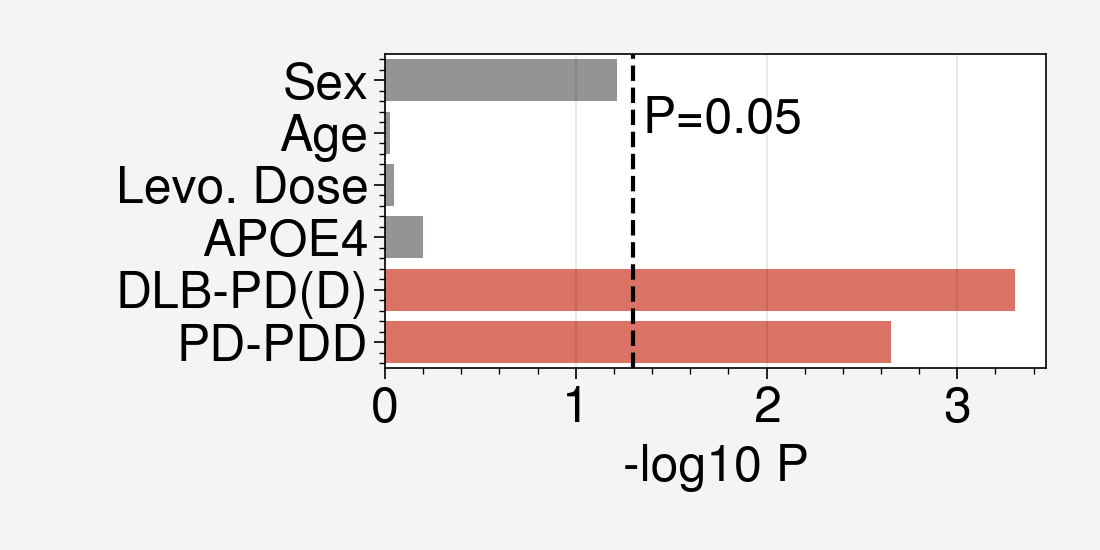

In [317]:
plt_df = (-np.log10(res_by)).transpose().reset_index()
fig, ax = plt.subplots(1, figsize=(5.5, 2.75))
sns.barplot(data=plt_df, y='index', x='p', orient = 'h', palette=['gray']*4+['#EE6352']*2)
plt.axvline(-np.log10(0.05), color='black', linestyle='--')
plt.text(-np.log10(0.05)+0.05, 1, 'P=0.05')
plt.tight_layout()
plt.ylabel('')
plt.xlabel('-log10 P')
plt.savefig('../figures/residual.svg', transparent=True)

## Plotting cross-site predictions

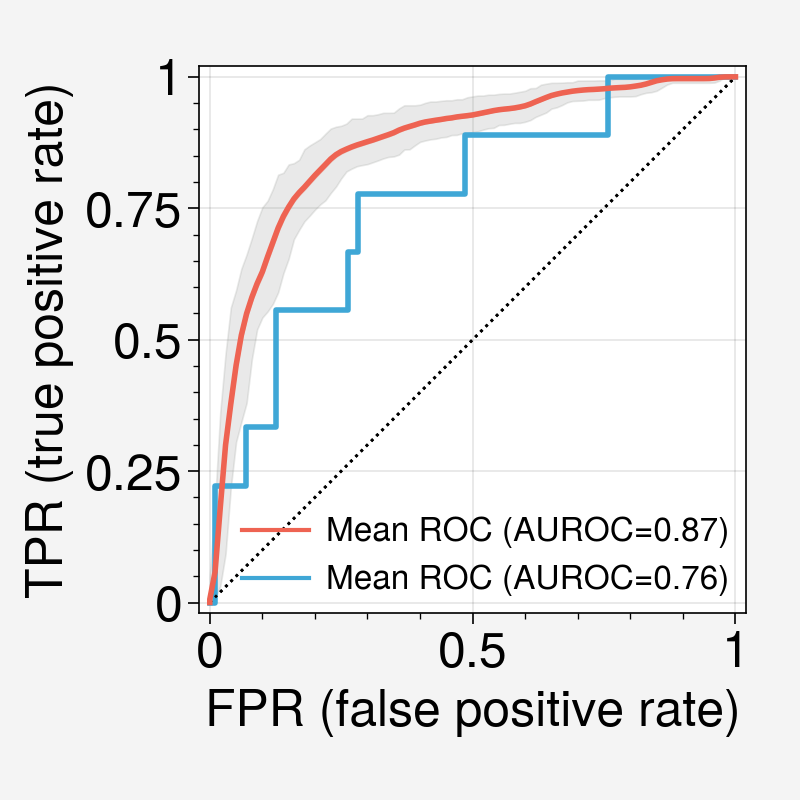

In [318]:
colors = ['#255957', "#EE6352", '#3FA7D6', "#FAC05E", "#59CD90"]

plt_df = pd.concat([preds, df.Group], axis=1)
plt_df = plt_df.loc[plt_df.Group.isin(['PD', 'LBD', 'PD_MCIDEM', 'HC']), :]
plt_df.Group = plt_df.Group.apply(lambda x: True if x in ['PD', 'LBD', 'PD_MCIDEM'] else False)
plt_df = plt_df.melt('Group').dropna()

plt_df2 = pd.DataFrame([y_test_site.reset_index(drop=True), pred_site], index=['Group', 'value']).transpose()
plt_df2.Group = plt_df2.Group.map({0:False, 1:True})

# plt_df = plt_df.loc[plt_df.variable==0, :]
x, y = plt_df.value, plt_df.Group

fig, ax = plt.subplots(1, figsize=(4,4))
# Compute the ROC curve...
pos_label = True
n_samples = 200
rocs = ru.compute_roc_bootstrap(X=x, y=y, pos_label=pos_label,
                             n_bootstrap=n_samples,
                             random_state=42,
                             return_mean=False)
ru.plot_mean_roc(rocs, show_ci=True, show_ti=True, color=colors[1], linewidth=2)

# plt_df = plt_df.loc[plt_df.variable==0, :]
x, y = plt_df2.value, plt_df2.Group

# Compute the ROC curve...
pos_label = True

roc = ru.compute_roc(X=x, y=y, pos_label=pos_label)

# To perform a ROC analysis using bootstrapping
ru.plot_roc(roc, color=colors[2], linewidth=2)

# plt.legend(loc=4, prop={'size': 10})

custom_lines = [Line2D([0], [0], color=colors[1], label='Scatter', markerfacecolor=colors[0], markersize=4),
                Line2D([0], [0], color=colors[2], label='Scatter', markerfacecolor=colors[1], markersize=4)]
plt.legend(custom_lines, ['Mean ROC (AUROC='+str(np.round(aucs_hc.mean()[1],2))+')', 'Mean ROC (AUROC='+str(np.round(auc,2))+')'], loc='lower right', prop={'size': 12}, frameon=False)
plt.tight_layout()
plt.savefig('../figures/auc_crosssite.svg', transparent=True)
plt.show()

## Plotting predicted values

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

HC vs. LBD: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.978e-25 U_stat=1.748e+03
LBD vs. ADD: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.013e-18 U_stat=8.491e+03
LBD vs. NDC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.279e-06 U_stat=1.743e+03
LBD vs. IDC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.705e-04 U_stat=1.186e+03


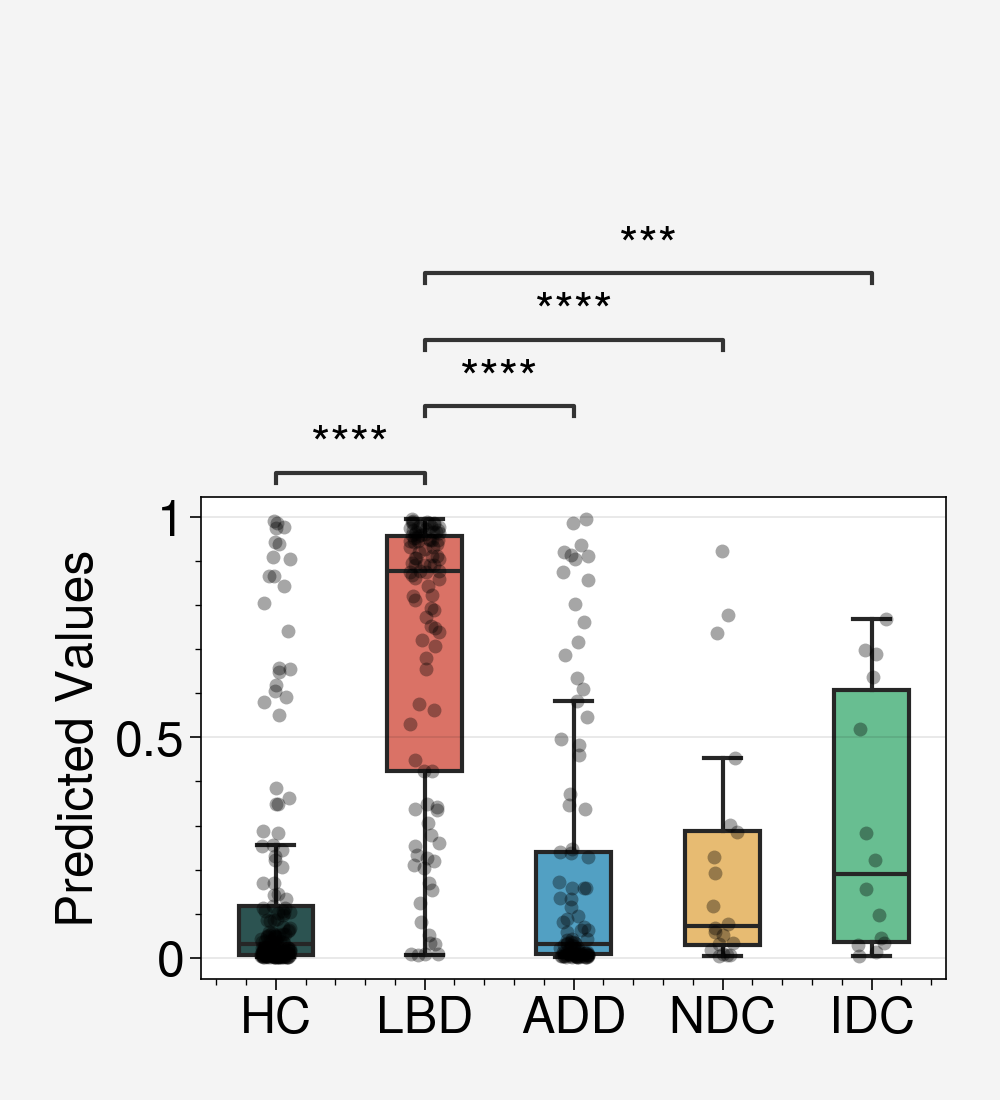

In [319]:
colors = ['#255957', "#EE6352", '#3FA7D6', "#FAC05E", "#59CD90"]

fig, ax = plt.subplots(1, figsize=(5,5.5))
plt_df = pd.concat([preds.mean(axis=1), df.Group], axis=1)
plt_df.columns = ['pred', 'Group']
plt_df.Group = plt_df.Group.apply(lambda x: 'LBD' if x in ['LBD', 'PD', 'PD_MCIDEM'] else 'IDC' if x=='IDCO' else 'ADD' if x=='AD' else x)

sns.stripplot(data=plt_df, x='Group', y='pred', order=['HC', 'LBD', 'ADD', 'NDC', 'IDC'], color='black', alpha=0.35)
sns.boxplot(data=plt_df, x='Group', y='pred', order=['HC', 'LBD', 'ADD', 'NDC', 'IDC'], palette=colors, 
            width=0.5, showfliers=False)#, boxprops={'facecolor':'None'})


plt.xlabel('')
plt.ylabel('Predicted Values')

pairs_=[("HC", "LBD"), ("ADD", "LBD"), ("IDC", "LBD"), ("NDC", "LBD")]
annotator = Annotator(ax, pairs_, data=plt_df, x='Group', y='pred', order=['HC', 'LBD', 'ADD', 'NDC', 'IDC'])
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction='bonferroni', text_offset=0)
annotator.apply_and_annotate()

plt.tight_layout()
plt.savefig('../figures/manuscript_boxplot_predictions.svg', transparent=True)

## Plotting performances

In [28]:
aucs = aucs_hc #aucs_hc #aucs_pd, hc
auprcs = auprcs_hc #auprcs_hc #auprcs_pd, hc
prevalences = prevalences_hc #prevalences_hc #prevalences_pd, hc

In [29]:
aucs_melt = aucs.melt()
aucs_melt['type'] = 'AUROC'
auprcs_melt = auprcs.melt()
auprcs_melt['type'] = 'AUPRC'
aucs_auprcs = pd.concat([aucs_melt, auprcs_melt], axis=0).reset_index(drop=True)

# aucs_auprcs['variable'] = aucs_auprcs['variable'].replace('HC-PD-PD_MCIDEM-LBD', 'HC-\nLBD').replace('AD-PD-PD_MCIDEM-LBD', 'AD-\nLBD').replace('IDC-PD-PD_MCIDEM-LBD', 'IDC-\nLBD').replace('NDC-PD-PD_MCIDEM-LBD', 'NDC-\nLBD')
aucs_auprcs['variable'] = aucs_auprcs['variable'].replace('HC-PD-PD_MCIDEM-LBD', 'HC-LBD').replace('AD-PD-PD_MCIDEM-LBD', 'ADD-\nLBD').replace('IDC-PD-PD_MCIDEM-LBD', 'IDC-\nLBD').replace('NDC-PD-PD_MCIDEM-LBD', 'NDC-\nLBD').replace('HC-AD', 'HC-ADD')

prevalences_melt = prevalences.melt()
prevalences_melt = prevalences_melt.groupby('variable').mean().reset_index()
# prevalences_melt['variable'] = prevalences_melt['variable'].replace('HC-PD-PD_MCIDEM-LBD', 'HC-\nLBD').replace('AD-PD-PD_MCIDEM-LBD', 'AD-\nLBD').replace('IDC-PD-PD_MCIDEM-LBD', 'IDC-\nLBD').replace('NDC-PD-PD_MCIDEM-LBD', 'NDC-\nLBD')
prevalences_melt['variable'] = prevalences_melt['variable'].replace('HC-PD-PD_MCIDEM-LBD', 'HC-LBD').replace('AD-PD-PD_MCIDEM-LBD', 'ADD-\nLBD').replace('IDC-PD-PD_MCIDEM-LBD', 'IDC-\nLBD').replace('NDC-PD-PD_MCIDEM-LBD', 'NDC-\nLBD').replace('HC-AD', 'HC-ADD')

prevalences_melt = prevalences_melt.set_index(prevalences_melt.variable)
prevalences_melt = prevalences_melt.loc[aucs_auprcs.variable.unique(), :]

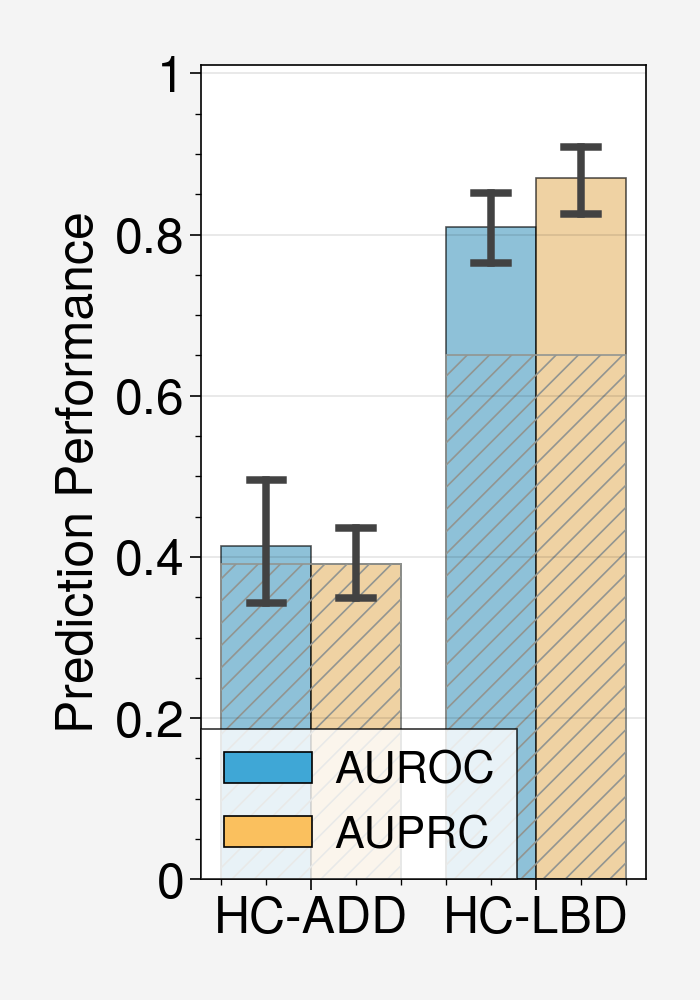

In [30]:
colors = ['#3FA7D6', '#FAC05E']

# fig, ax = plt.subplots(1, figsize=(4.5,5))
fig, ax = plt.subplots(1, figsize=(3.5,5))
sns.barplot(x="variable", y="value",
            hue="type", edgecolor=".0", alpha=0.65,
            data=aucs_auprcs, capsize=.15, palette=colors)
plt.bar(prevalences_melt.variable, prevalences_melt.value, fill=False, hatch='///', edgecolor='gray')

# plt.xticks(rotation=90)
plt.ylabel('Prediction Performance')
plt.xlabel('')
custom_lines = [Patch(facecolor=colors[0], edgecolor='black', label='Color Patch'),
                Patch(facecolor=colors[1], edgecolor='black', label='Color Patch')]

plt.legend(custom_lines, ['AUROC', 'AUPRC'], loc='lower left', prop={'size': 16})
plt.ylim(0, 1.01)
plt.title('')
plt.tight_layout()

# plt.show()
plt.savefig('../figures/manuscript_auc_majorGroups_Stanford.svg', transparent=True)
# plt.savefig('../figures/manuscript_auc_majorGroups_all.svg', transparent=True)
# plt.savefig('../figures/manuscript_auc_transfer.svg', transparent=True)

# PD subgroups Prediction

In [330]:
# pairs = [['HC', 'AD'], ['HC', 'PD', 'PD_MCIDEM','LBD']]#, ['AD', 'PD', 'PD_MCIDEM','LBD'], ['IDCO', 'PD', 'PD_MCIDEM','LBD']]
transfer_pairs = [['PD', 'LBD'], ['PD', 'PD_MCIDEM'], ['LBD', 'PD_MCIDEM'], ['AD','LBD'], ['AD','PD_MCIDEM'], ['AD','PD']]
pairs = [['HC','LBD'], ['HC','PD_MCIDEM'], ['HC','PD']]#,, ['PD','LBD'], ['PD','PD_MCIDEM'], ['PD_MCIDEM','LBD']]
n_iters = 10
aucs_lbd = {'-'.join(p):[] for p in pairs}
auprcs_lbd = {'-'.join(p):[] for p in pairs}
prevalences_lbd = {'-'.join(p):[] for p in pairs}

aucs_Transfer = {'-'.join(p):[] for p in transfer_pairs}
auprcs_Transfer = {'-'.join(p):[] for p in transfer_pairs}
prevalences_Transfer = {'-'.join(p):[] for p in transfer_pairs}

aucs_unexpectedTransfer = {'-'.join(p):[] for p in transfer_pairs[0:3]}
auprcs_unexpectedTransfer = {'-'.join(p):[] for p in transfer_pairs[0:3]}
prevalences_unexpectedTransfer = {'-'.join(p):[] for p in transfer_pairs[0:3]}

preds = pd.DataFrame(np.full([df.shape[0], n_iters], np.nan), index=df.index)
wts = {'-'.join(p):np.zeros((n_iters, df.loc[:, imm_feat].loc[df.Group.isin(p), :].shape[1])) for p in pairs}

# df = df.loc[df.Site!='NCRAD', :]

for pair in pairs:
    print(pair)
    X = df.loc[:, imm_feat].loc[df.Group.isin(pair), :]
    y = df.loc[df.Group.isin(pair), 'Group'].apply(lambda x: 0 if x in [pair[0]] else 1)

    # if pair!=['HC','AD']:
    drop_indices = get_drop_index(df, pair)
    X = X.drop(drop_indices)
    y = y.drop(drop_indices)
    print(X.shape[0])

    # X = preprocessing.quantile_transform(X)

    for i in range(n_iters):
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=i*3)
        train_idx, test_idx = X_train.index, X_test.index
        X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
        df_test = df.loc[test_idx, :]
        

        # model = RandomForestClassifier(n_jobs=-1)#, class_weight='balanced_subsample', criterion='entropy')
        model = LGBMClassifier(n_jobs=-1, class_weight='balanced', n_estimators =500, learning_rate=0.06)
        # model = LogisticRegression(max_iter=10000, class_weight='balanced', penalty='elasticnet', solver='saga', l1_ratio=1, n_jobs=-1)
        # model = SVC(probability=True, kernel='linear', C=500)
        model.fit(X_train, y_train.values)
        
        pred = model.predict_proba(X_test)[:, 1]
        preds.loc[test_idx, i] = pred
        
        wts['-'.join(pair)][i, :] = model.feature_importances_
    
        auc = roc_auc_score(y_test, pred)
        aucs_lbd['-'.join(pair)] += [auc]
        auprc = average_precision_score(y_test, pred)
        auprcs_lbd['-'.join(pair)] += [auprc]
        prevalence = (y_test==1).sum()/len(y_test)
        prevalences_lbd['-'.join(pair)] += [prevalence]

        if pair == ['HC','PD_MCIDEM']:
            # predict AD vs PD
            condition = ( (df.Group==transfer_pairs[2][0]) | ( (pd.Series(df.index.isin(test_idx), index=df.index)) & (df.Group==transfer_pairs[2][1]) ) )
            X_sel = (df.loc[:, imm_feat].loc[condition, :]).to_numpy()
            y_sel = df.loc[condition, 'Group'].apply(lambda x: 0 if x!='PD_MCIDEM' else 1)
            pred = model.predict_proba(X_sel)[:, 1]
            preds.loc[df.loc[condition, :].index, i] = pred
            auc = roc_auc_score(y_sel, pred)
            aucs_Transfer['-'.join(transfer_pairs[2])] += [auc]
            auprc = average_precision_score(y_sel, pred)
            auprcs_Transfer['-'.join(transfer_pairs[2])] += [auprc]
            prevalence = (y_sel==1).sum()/len(y_sel)
            prevalences_Transfer['-'.join(transfer_pairs[2])] += [prevalence]

            # predict AD vs PD
            condition = ( (df.Group==transfer_pairs[1][0]) | ( (pd.Series(df.index.isin(test_idx), index=df.index)) & (df.Group==transfer_pairs[1][1]) ) )
            X_sel = (df.loc[:, imm_feat].loc[condition, :]).to_numpy()
            y_sel = df.loc[condition, 'Group'].apply(lambda x: 0 if x!='PD_MCIDEM' else 1)
            pred = model.predict_proba(X_sel)[:, 1]
            preds.loc[df.loc[condition, :].index, i] = pred
            auc = roc_auc_score(y_sel, pred)
            aucs_Transfer['-'.join(transfer_pairs[1])] += [auc]
            auprc = average_precision_score(y_sel, pred)
            auprcs_Transfer['-'.join(transfer_pairs[1])] += [auprc]
            prevalence = (y_sel==1).sum()/len(y_sel)
            prevalences_Transfer['-'.join(transfer_pairs[1])] += [prevalence]

            # predict AD vs PD
            condition = ( (df.Group==transfer_pairs[0][0]) | (df.Group==transfer_pairs[0][1]) )
            X_sel = (df.loc[:, imm_feat].loc[condition, :]).to_numpy()
            y_sel = df.loc[condition, 'Group'].apply(lambda x: 0 if x!='LBD' else 1)
            pred = model.predict_proba(X_sel)[:, 1]
            preds.loc[df.loc[condition, :].index, i] = pred
            auc = roc_auc_score(y_sel, pred)
            aucs_unexpectedTransfer['-'.join(transfer_pairs[0])] += [auc]
            auprc = average_precision_score(y_sel, pred)
            auprcs_unexpectedTransfer['-'.join(transfer_pairs[0])] += [auprc]
            prevalence = (y_sel==1).sum()/len(y_sel)
            prevalences_unexpectedTransfer['-'.join(transfer_pairs[0])] += [prevalence]

            # predict AD vs PD
            condition = ( (df.Group==transfer_pairs[4][0]) | ( (pd.Series(df.index.isin(test_idx), index=df.index)) & (df.Group==transfer_pairs[4][1]) ) )
            X_sel = (df.loc[:, imm_feat].loc[condition, :]).to_numpy()
            y_sel = df.loc[condition, 'Group'].apply(lambda x: 0 if x!='PD_MCIDEM' else 1)
            pred = model.predict_proba(X_sel)[:, 1]
            preds.loc[df.loc[condition, :].index, i] = pred
            auc = roc_auc_score(y_sel, pred)
            aucs_Transfer['-'.join(transfer_pairs[4])] += [auc]
            auprc = average_precision_score(y_sel, pred)
            auprcs_Transfer['-'.join(transfer_pairs[4])] += [auprc]
            prevalence = (y_sel==1).sum()/len(y_sel)
            prevalences_Transfer['-'.join(transfer_pairs[4])] += [prevalence]

        if pair == ['HC','PD']:
            # predict AD vs PD
            condition = ( (df.Group==transfer_pairs[1][1]) | ( (pd.Series(df.index.isin(test_idx), index=df.index)) & (df.Group==transfer_pairs[1][0]) ) )
            X_sel = (df.loc[:, imm_feat].loc[condition, :]).to_numpy()
            y_sel = df.loc[condition, 'Group'].apply(lambda x: 0 if x!='PD' else 1)
            pred = model.predict_proba(X_sel)[:, 1]
            preds.loc[df.loc[condition, :].index, i] = pred
            auc = roc_auc_score(y_sel, pred)
            aucs_Transfer['-'.join(transfer_pairs[1])] += [auc]
            auprc = average_precision_score(y_sel, pred)
            auprcs_Transfer['-'.join(transfer_pairs[1])] += [auprc]
            prevalence = (y_sel==1).sum()/len(y_sel)
            prevalences_Transfer['-'.join(transfer_pairs[1])] += [prevalence]

            # predict AD vs PD
            condition = ( (df.Group==transfer_pairs[0][1]) | ( (pd.Series(df.index.isin(test_idx), index=df.index)) & (df.Group==transfer_pairs[0][0]) ) )
            X_sel = (df.loc[:, imm_feat].loc[condition, :]).to_numpy()
            y_sel = df.loc[condition, 'Group'].apply(lambda x: 0 if x!='PD' else 1)
            pred = model.predict_proba(X_sel)[:, 1]
            preds.loc[df.loc[condition, :].index, i] = pred
            auc = roc_auc_score(y_sel, pred)
            aucs_Transfer['-'.join(transfer_pairs[0])] += [auc]
            auprc = average_precision_score(y_sel, pred)
            auprcs_Transfer['-'.join(transfer_pairs[0])] += [auprc]
            prevalence = (y_sel==1).sum()/len(y_sel)
            prevalences_Transfer['-'.join(transfer_pairs[0])] += [prevalence]

            # predict AD vs PD
            condition = ( (df.Group==transfer_pairs[2][0]) | (df.Group==transfer_pairs[2][1]) )
            X_sel = (df.loc[:, imm_feat].loc[condition, :]).to_numpy()
            y_sel = df.loc[condition, 'Group'].apply(lambda x: 0 if x!='PD_MCIDEM' else 1)
            pred = model.predict_proba(X_sel)[:, 1]
            preds.loc[df.loc[condition, :].index, i] = pred
            auc = roc_auc_score(y_sel, pred)
            aucs_unexpectedTransfer['-'.join(transfer_pairs[2])] += [auc]
            auprc = average_precision_score(y_sel, pred)
            auprcs_unexpectedTransfer['-'.join(transfer_pairs[2])] += [auprc]
            prevalence = (y_sel==1).sum()/len(y_sel)
            prevalences_unexpectedTransfer['-'.join(transfer_pairs[2])] += [prevalence]

            # predict AD vs PD
            condition = ( (df.Group==transfer_pairs[5][0]) | ( (pd.Series(df.index.isin(test_idx), index=df.index)) & (df.Group==transfer_pairs[5][1]) ) )
            X_sel = (df.loc[:, imm_feat].loc[condition, :]).to_numpy()
            y_sel = df.loc[condition, 'Group'].apply(lambda x: 0 if x!='PD' else 1)
            pred = model.predict_proba(X_sel)[:, 1]
            preds.loc[df.loc[condition, :].index, i] = pred
            auc = roc_auc_score(y_sel, pred)
            aucs_Transfer['-'.join(transfer_pairs[5])] += [auc]
            auprc = average_precision_score(y_sel, pred)
            auprcs_Transfer['-'.join(transfer_pairs[5])] += [auprc]
            prevalence = (y_sel==1).sum()/len(y_sel)
            prevalences_Transfer['-'.join(transfer_pairs[5])] += [prevalence]
            
        if pair == ['HC','LBD']:
            # predict AD vs PD
            condition = ( (df.Group==transfer_pairs[2][1]) | ( (pd.Series(df.index.isin(test_idx), index=df.index)) & (df.Group==transfer_pairs[2][0]) ) )
            X_sel = (df.loc[:, imm_feat].loc[condition, :]).to_numpy()
            y_sel = df.loc[condition, 'Group'].apply(lambda x: 0 if x!='LBD' else 1)
            pred = model.predict_proba(X_sel)[:, 1]
            preds.loc[df.loc[condition, :].index, i] = pred
            auc = roc_auc_score(y_sel, pred)
            aucs_Transfer['-'.join(transfer_pairs[2])] += [auc]
            auprc = average_precision_score(y_sel, pred)
            auprcs_Transfer['-'.join(transfer_pairs[2])] += [auprc]
            prevalence = (y_sel==1).sum()/len(y_sel)
            prevalences_Transfer['-'.join(transfer_pairs[2])] += [prevalence]

            # predict AD vs PD
            condition = ( (df.Group==transfer_pairs[0][0]) | ( (pd.Series(df.index.isin(test_idx), index=df.index)) & (df.Group==transfer_pairs[0][1]) ) )
            X_sel = (df.loc[:, imm_feat].loc[condition, :]).to_numpy()
            y_sel = df.loc[condition, 'Group'].apply(lambda x: 0 if x!='LBD' else 1)
            pred = model.predict_proba(X_sel)[:, 1]
            preds.loc[df.loc[condition, :].index, i] = pred
            auc = roc_auc_score(y_sel, pred)
            aucs_Transfer['-'.join(transfer_pairs[0])] += [auc]
            auprc = average_precision_score(y_sel, pred)
            auprcs_Transfer['-'.join(transfer_pairs[0])] += [auprc]
            prevalence = (y_sel==1).sum()/len(y_sel)
            prevalences_Transfer['-'.join(transfer_pairs[0])] += [prevalence]

            # predict AD vs PD
            condition = ( (df.Group==transfer_pairs[1][0]) | (df.Group==transfer_pairs[1][1]) )
            X_sel = (df.loc[:, imm_feat].loc[condition, :]).to_numpy()
            y_sel = df.loc[condition, 'Group'].apply(lambda x: 0 if x!='PD' else 1)
            pred = model.predict_proba(X_sel)[:, 1]
            preds.loc[df.loc[condition, :].index, i] = pred
            auc = roc_auc_score(y_sel, pred)
            aucs_unexpectedTransfer['-'.join(transfer_pairs[1])] += [auc]
            auprc = average_precision_score(y_sel, pred)
            auprcs_unexpectedTransfer['-'.join(transfer_pairs[1])] += [auprc]
            prevalence = (y_sel==1).sum()/len(y_sel)
            prevalences_unexpectedTransfer['-'.join(transfer_pairs[1])] += [prevalence]

            # predict AD vs PD
            condition = ( (df.Group==transfer_pairs[3][0]) | ( (pd.Series(df.index.isin(test_idx), index=df.index)) & (df.Group==transfer_pairs[3][1]) ) )
            X_sel = (df.loc[:, imm_feat].loc[condition, :]).to_numpy()
            y_sel = df.loc[condition, 'Group'].apply(lambda x: 0 if x!='LBD' else 1)
            pred = model.predict_proba(X_sel)[:, 1]
            preds.loc[df.loc[condition, :].index, i] = pred
            auc = roc_auc_score(y_sel, pred)
            aucs_Transfer['-'.join(transfer_pairs[3])] += [auc]
            auprc = average_precision_score(y_sel, pred)
            auprcs_Transfer['-'.join(transfer_pairs[3])] += [auprc]
            prevalence = (y_sel==1).sum()/len(y_sel)
            prevalences_Transfer['-'.join(transfer_pairs[3])] += [prevalence]
            
    wts['-'.join(pair)] = wts['-'.join(pair)].mean(axis=0)

aucs_lbd = pd.DataFrame.from_dict(aucs_lbd, orient='index').T
auprcs_lbd = pd.DataFrame.from_dict(auprcs_lbd, orient='index').T
prevalences_lbd = pd.DataFrame.from_dict(prevalences_lbd, orient='index').T

aucs_Transfer = pd.DataFrame.from_dict(aucs_Transfer, orient='index').T
auprcs_Transfer = pd.DataFrame.from_dict(auprcs_Transfer, orient='index').T
prevalences_Transfer = pd.DataFrame.from_dict(prevalences_Transfer, orient='index').T

aucs_unexpectedTransfer = pd.DataFrame.from_dict(aucs_unexpectedTransfer, orient='index').T
auprcs_unexpectedTransfer = pd.DataFrame.from_dict(auprcs_unexpectedTransfer, orient='index').T
prevalences_unexpectedTransfer = pd.DataFrame.from_dict(prevalences_unexpectedTransfer, orient='index').T

wts = pd.DataFrame(wts, index=X.columns)
wts.to_csv('../results/LGBM_wt_PDLBDGroup.csv')

['HC', 'LBD']
170
['HC', 'PD_MCIDEM']
170
['HC', 'PD']
210


## Plotting performances

In [421]:
aucs = aucs_Transfer
auprcs = auprcs_Transfer
prevalences = prevalences_Transfer

In [422]:
aucs_melt = aucs.melt()
aucs_melt['type'] = 'AUROC'
auprcs_melt = auprcs.melt()
auprcs_melt['type'] = 'AUPRC'
aucs_auprcs = pd.concat([aucs_melt, auprcs_melt], axis=0).reset_index(drop=True)
if ['HC', 'PD', 'PD_MCIDEM','LBD'] in pairs:
    aucs_auprcs['variable'] = aucs_auprcs['variable'].replace('HC-PD-PD_MCIDEM-LBD', 'HC-\nPD/DLB').replace('AD-PD-PD_MCIDEM-LBD', 'ADD-\nPD/DLB').replace('IDC-PD-PD_MCIDEM-LBD', 'IDC-\nPD/DLB').replace('NDC-PD-PD_MCIDEM-LBD', 'NDC-\nPD/DLB')

prevalences_melt = prevalences.melt()
prevalences_melt = prevalences_melt.groupby('variable').mean().reset_index()
if ['HC', 'PD', 'PD_MCIDEM','LBD'] in pairs:
    prevalences_melt['variable'] = prevalences_melt['variable'].replace('HC-PD-PD_MCIDEM-LBD', 'HC-\nPD/DLB').replace('AD-PD-PD_MCIDEM-LBD', 'ADD-\nPD/DLB').replace('IDC-PD-PD_MCIDEM-LBD', 'IDC-\nPD/DLB').replace('NDC-PD-PD_MCIDEM-LBD', 'NDC-\nPD/DLB')

prevalences_melt = prevalences_melt.set_index(prevalences_melt.variable)
prevalences_melt = prevalences_melt.loc[aucs_auprcs.variable.unique(), :]

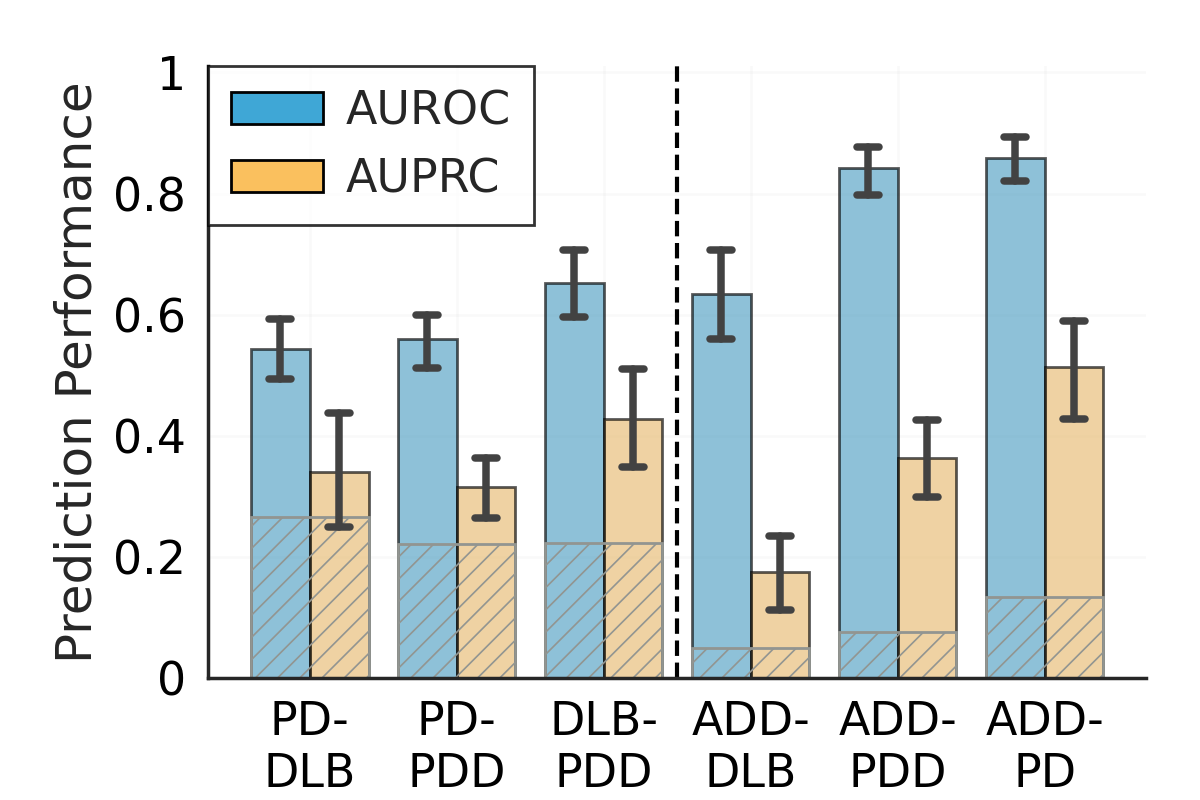

In [423]:
colors = ['#3FA7D6', '#FAC05E']

sns.set(font_scale=1.5)  # crazy big
sns.set_style("white")

aspect = 1.5
g = sns.catplot(x="variable", y="value",
                hue="type", edgecolor=".0", alpha=0.65,
                data=aucs_auprcs, kind="bar", legend=False, capsize=.15,
                height=4, aspect=aspect, palette=colors)
# g = sns.stripplot(x="variable", y="value", hue="type", data=aucs_auprcs, 
#                   palette=colors, dodge=True, size=10, alpha=0.25)
plt.bar(prevalences_melt.variable, prevalences_melt.value, fill=False, hatch='///', edgecolor='gray')

plt.tight_layout()
# plt.xticks(rotation=90)
plt.ylabel('Prediction Performance')
plt.xlabel('')
custom_lines = [Patch(facecolor=colors[0], edgecolor='black', label='Color Patch'),
                Patch(facecolor=colors[1], edgecolor='black', label='Color Patch')]

plt.legend(custom_lines, ['AUROC', 'AUPRC'], loc='upper left')
plt.ylim(0, 1.01)
plt.grid()
plt.tight_layout()
plt.axvline(2.5, linestyle='--', color='black')
# plt.axvline(5.5, linestyle='--', color='black')
# plt.xticks(np.arange(9), ['HC-\nDLB', 'HC-\nPDD', 'HC-\nPD', 'AD-\nDLB', 'AD-\nPDD', 'AD-\nPD', 'PD-\nDLB', 'PD-\nPDD', 'DLB-\nPDD']) 
plt.xticks(np.arange(6), ['PD-\nDLB', 'PD-\nPDD', 'DLB-\nPDD', 'ADD-\nDLB', 'ADD-\nPDD', 'ADD-\nPD', ]) 
plt.savefig('../figures/manuscript_auc_NDCGroupsTransferred.svg')
# plt.savefig('test.svg')

In [416]:
aucs = aucs_lbd
auprcs = auprcs_lbd
prevalences = prevalences_lbd

aucs_melt = aucs.melt()
aucs_melt['type'] = 'AUROC'
auprcs_melt = auprcs.melt()
auprcs_melt['type'] = 'AUPRC'
aucs_auprcs = pd.concat([aucs_melt, auprcs_melt], axis=0).reset_index(drop=True)
if ['HC', 'PD', 'PD_MCIDEM','LBD'] in pairs:
    aucs_auprcs['variable'] = aucs_auprcs['variable'].replace('HC-PD-PD_MCIDEM-LBD', 'HC-\nPD/DLB').replace('AD-PD-PD_MCIDEM-LBD', 'AD-\nPD/DLB').replace('IDC-PD-PD_MCIDEM-LBD', 'IDC-\nPD/DLB').replace('NDC-PD-PD_MCIDEM-LBD', 'NDC-\nPD/DLB')

prevalences_melt = prevalences.melt()
prevalences_melt = prevalences_melt.groupby('variable').mean().reset_index()
if ['HC', 'PD', 'PD_MCIDEM','LBD'] in pairs:
    prevalences_melt['variable'] = prevalences_melt['variable'].replace('HC-PD-PD_MCIDEM-LBD', 'HC-\nPD/DLB').replace('AD-PD-PD_MCIDEM-LBD', 'AD-\nPD/DLB').replace('IDC-PD-PD_MCIDEM-LBD', 'IDC-\nPD/DLB').replace('NDC-PD-PD_MCIDEM-LBD', 'NDC-\nPD/DLB')

prevalences_melt = prevalences_melt.set_index(prevalences_melt.variable)
prevalences_melt = prevalences_melt.loc[aucs_auprcs.variable.unique(), :]

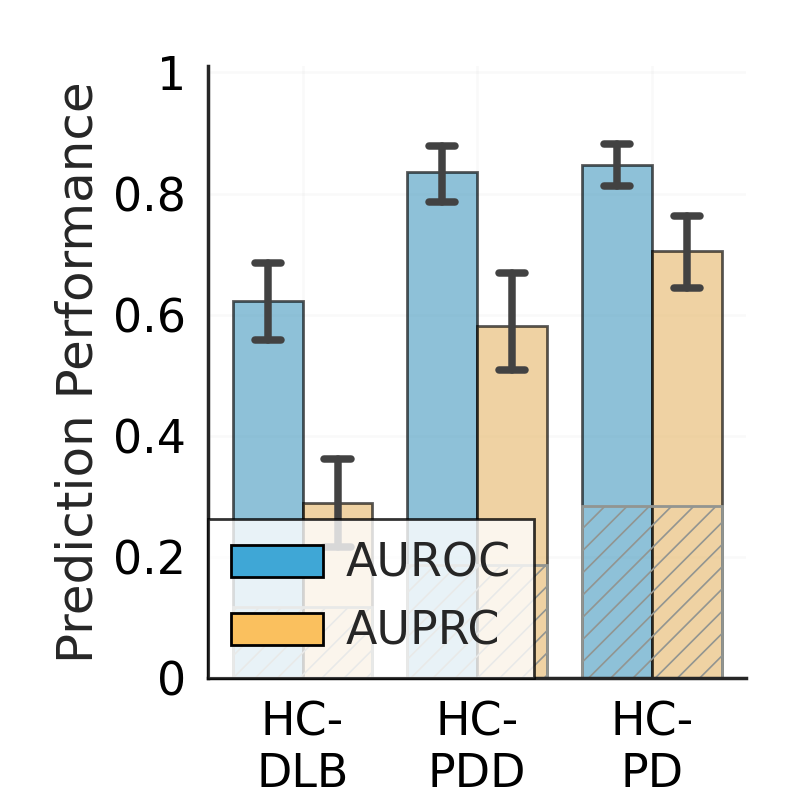

In [417]:
colors = ['#3FA7D6', '#FAC05E']

sns.set(font_scale=1.5)  # crazy big
sns.set_style("white")

aspect = 1
g = sns.catplot(x="variable", y="value",
                hue="type", edgecolor=".0", alpha=0.65,
                data=aucs_auprcs, kind="bar", legend=False, capsize=.15,
                height=4, aspect=aspect, palette=colors)
# g = sns.stripplot(x="variable", y="value", hue="type", data=aucs_auprcs, 
#                   palette=colors, dodge=True, size=10, alpha=0.25)
plt.bar(prevalences_melt.variable, prevalences_melt.value, fill=False, hatch='///', edgecolor='gray')

plt.tight_layout()
# plt.xticks(rotation=90)
plt.ylabel('Prediction Performance')
plt.xlabel('')
custom_lines = [Patch(facecolor=colors[0], edgecolor='black', label='Color Patch'),
                Patch(facecolor=colors[1], edgecolor='black', label='Color Patch')]

plt.legend(custom_lines, ['AUROC', 'AUPRC'], loc='lower left')
plt.ylim(0, 1.01)
plt.tight_layout()
plt.grid()
# plt.axvline(2.5, linestyle='--', color='black')
# plt.axvline(5.5, linestyle='--', color='black')
# plt.xticks(np.arange(9), ['HC-\nDLB', 'HC-\nPDD', 'HC-\nPD', 'AD-\nDLB', 'AD-\nPDD', 'AD-\nPD', 'PD-\nDLB', 'PD-\nPDD', 'DLB-\nPDD']) 
plt.xticks(np.arange(3), ['HC-\nDLB', 'HC-\nPDD', 'HC-\nPD']) 
plt.savefig('../figures/manuscript_auc_NDCGroups.svg')

In [418]:
aucs = aucs_unexpectedTransfer
auprcs = auprcs_unexpectedTransfer
prevalences = prevalences_unexpectedTransfer

aucs_melt = aucs.melt()
aucs_melt['type'] = 'AUROC'
auprcs_melt = auprcs.melt()
auprcs_melt['type'] = 'AUPRC'
aucs_auprcs = pd.concat([aucs_melt, auprcs_melt], axis=0).reset_index(drop=True)
if ['HC', 'PD', 'PD_MCIDEM','LBD'] in pairs:
    aucs_auprcs['variable'] = aucs_auprcs['variable'].replace('HC-PD-PD_MCIDEM-LBD', 'HC-\nPD/DLB').replace('AD-PD-PD_MCIDEM-LBD', 'AD-\nPD/DLB').replace('IDC-PD-PD_MCIDEM-LBD', 'IDC-\nPD/DLB').replace('NDC-PD-PD_MCIDEM-LBD', 'NDC-\nPD/DLB')

prevalences_melt = prevalences.melt()
prevalences_melt = prevalences_melt.groupby('variable').mean().reset_index()
if ['HC', 'PD', 'PD_MCIDEM','LBD'] in pairs:
    prevalences_melt['variable'] = prevalences_melt['variable'].replace('HC-PD-PD_MCIDEM-LBD', 'HC-\nPD/DLB').replace('AD-PD-PD_MCIDEM-LBD', 'AD-\nPD/DLB').replace('IDC-PD-PD_MCIDEM-LBD', 'IDC-\nPD/DLB').replace('NDC-PD-PD_MCIDEM-LBD', 'NDC-\nPD/DLB')

prevalences_melt = prevalences_melt.set_index(prevalences_melt.variable)
prevalences_melt = prevalences_melt.loc[aucs_auprcs.variable.unique(), :]

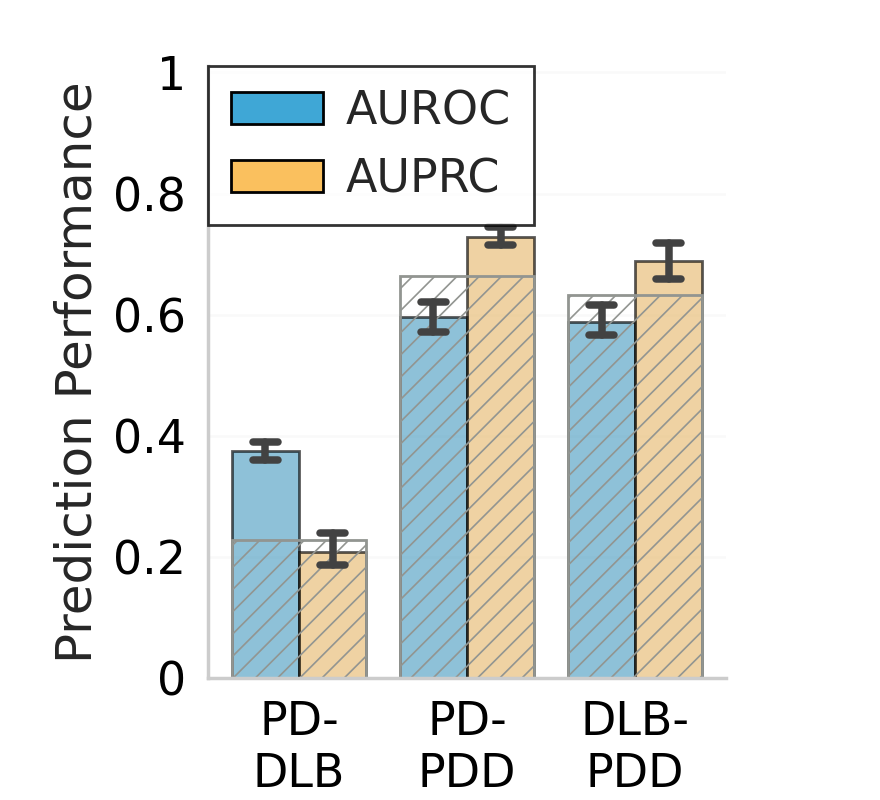

In [419]:
colors = ['#3FA7D6', '#FAC05E']

sns.set(font_scale=1.5)  # crazy big
sns.set_style("whitegrid")

aspect = 1.1
g = sns.catplot(x="variable", y="value",
                hue="type", edgecolor=".0", alpha=0.65,
                data=aucs_auprcs, kind="bar", legend=False, capsize=.15,
                height=4, aspect=aspect, palette=colors)
# g = sns.stripplot(x="variable", y="value", hue="type", data=aucs_auprcs, 
#                   palette=colors, dodge=True, size=10, alpha=0.25)
plt.bar(prevalences_melt.variable, prevalences_melt.value, fill=False, hatch='///', edgecolor='gray')

plt.tight_layout()
# plt.xticks(rotation=90)
plt.ylabel('Prediction Performance')
plt.xlabel('')
custom_lines = [Patch(facecolor=colors[0], edgecolor='black', label='Color Patch'),
                Patch(facecolor=colors[1], edgecolor='black', label='Color Patch')]

plt.legend(custom_lines, ['AUROC', 'AUPRC'], loc='upper left')
plt.ylim(0, 1.01)
plt.tight_layout()
# plt.axvline(2.5, linestyle='--', color='black')
# plt.axvline(5.5, linestyle='--', color='black')
# plt.xticks(np.arange(9), ['HC-\nDLB', 'HC-\nPDD', 'HC-\nPD', 'AD-\nDLB', 'AD-\nPDD', 'AD-\nPD', 'PD-\nDLB', 'PD-\nPDD', 'DLB-\nPDD']) 
plt.xticks(np.arange(3), ['PD-\nDLB', 'PD-\nPDD', 'DLB-\nPDD'])
plt.savefig('../figures/manuscript_auc_NDCGroupsUnexpected.svg')

# Plot Corr network

In [343]:
from sklearn.manifold import TSNE
import networkx as nx
from scipy.stats import pearsonr, pointbiserialr
import joblib
from scipy.stats import t

## plot by signaling color

In [344]:
def calculate_pvalue(r, n):
    t_stat = r/np.sqrt((1-r**2)/(n-2))
    return (1 - t.cdf(x=t_stat, df=n-2)) * 2

df_HC = df.loc[df.Group.isin(['HC']), :].loc[:, imm_feat]#.drop(['Age'], axis=1)
cor = df_HC.corr()
# col_names = pd.Series(cor.columns).apply(lambda x: x[0]+'-'+x[1])
# cor.columns = col_names
# cor.index = col_names
cor_p = cor.apply(calculate_pvalue, args=[df_HC.shape[0]-2])
cor_p = cor_p * (cor_p.shape[0]*cor_p.shape[1])/2

In [345]:
cor_melt = cor.melt()
cor_melt.index = np.array((cor.index.tolist())*len(cor.columns))
cor_melt = cor_melt.reset_index()
cor_melt.columns = ['src', 'dest', 'value']
edge_mat = cor_melt.loc[(cor_melt.value!=1) & (np.abs(cor_melt.value)>0.7), :]
# edge_mat['src_i'] = edge_mat.src.apply(lambda x: np.where(cor.columns==x)[0][0])
# edge_mat['dest_i'] = edge_mat.dest.apply(lambda x: np.where(cor.columns==x)[0][0])

In [346]:
reducer = TSNE(random_state=1)
xy = reducer.fit_transform(cor)

In [352]:
G=nx.Graph()
for i, nodename in enumerate(cor.columns):#range(xy.shape[0]):
    # color = ['black' if 'Freq' in nodename else '#AC80FF' if 'US' in nodename else '#3D518C' if 'LPS' in nodename else '#F6828C' if 'IL6' in nodename else '#A4C2A5'][0]
    # color = ['#255957' if 'Freq' in nodename else '#FAC05E' if 'US' in nodename else '#EE6352' if 'LPS' in nodename else '#59CD90' if 'IL6' in nodename else '#3FA7D6'][0]
    color = ['black' if 'Freq' in nodename else '#AC80FF' if '450_50' in nodename else '#AFDEDC' if '515_20' in nodename else '#F6828C' if '586_15' in nodename \
             else '#091540' if '610_20' in nodename else '#3D518C' if '660_20' in nodename else '#A4C2A5' if '780_60' in nodename else '#51A3A3'][0]
    G.add_node(nodename, pos=(xy[i,0], xy[i,1]), color=color, size=100)

for i in range(edge_mat.shape[0]):
    G.add_edge(edge_mat.iloc[i, 0], edge_mat.iloc[i, 1])#, weight=3)
    
pos = nx.get_node_attributes(G, 'pos')
size = np.abs(list(nx.get_node_attributes(G, 'size').values()))
color = list(nx.get_node_attributes(G, 'color').values())

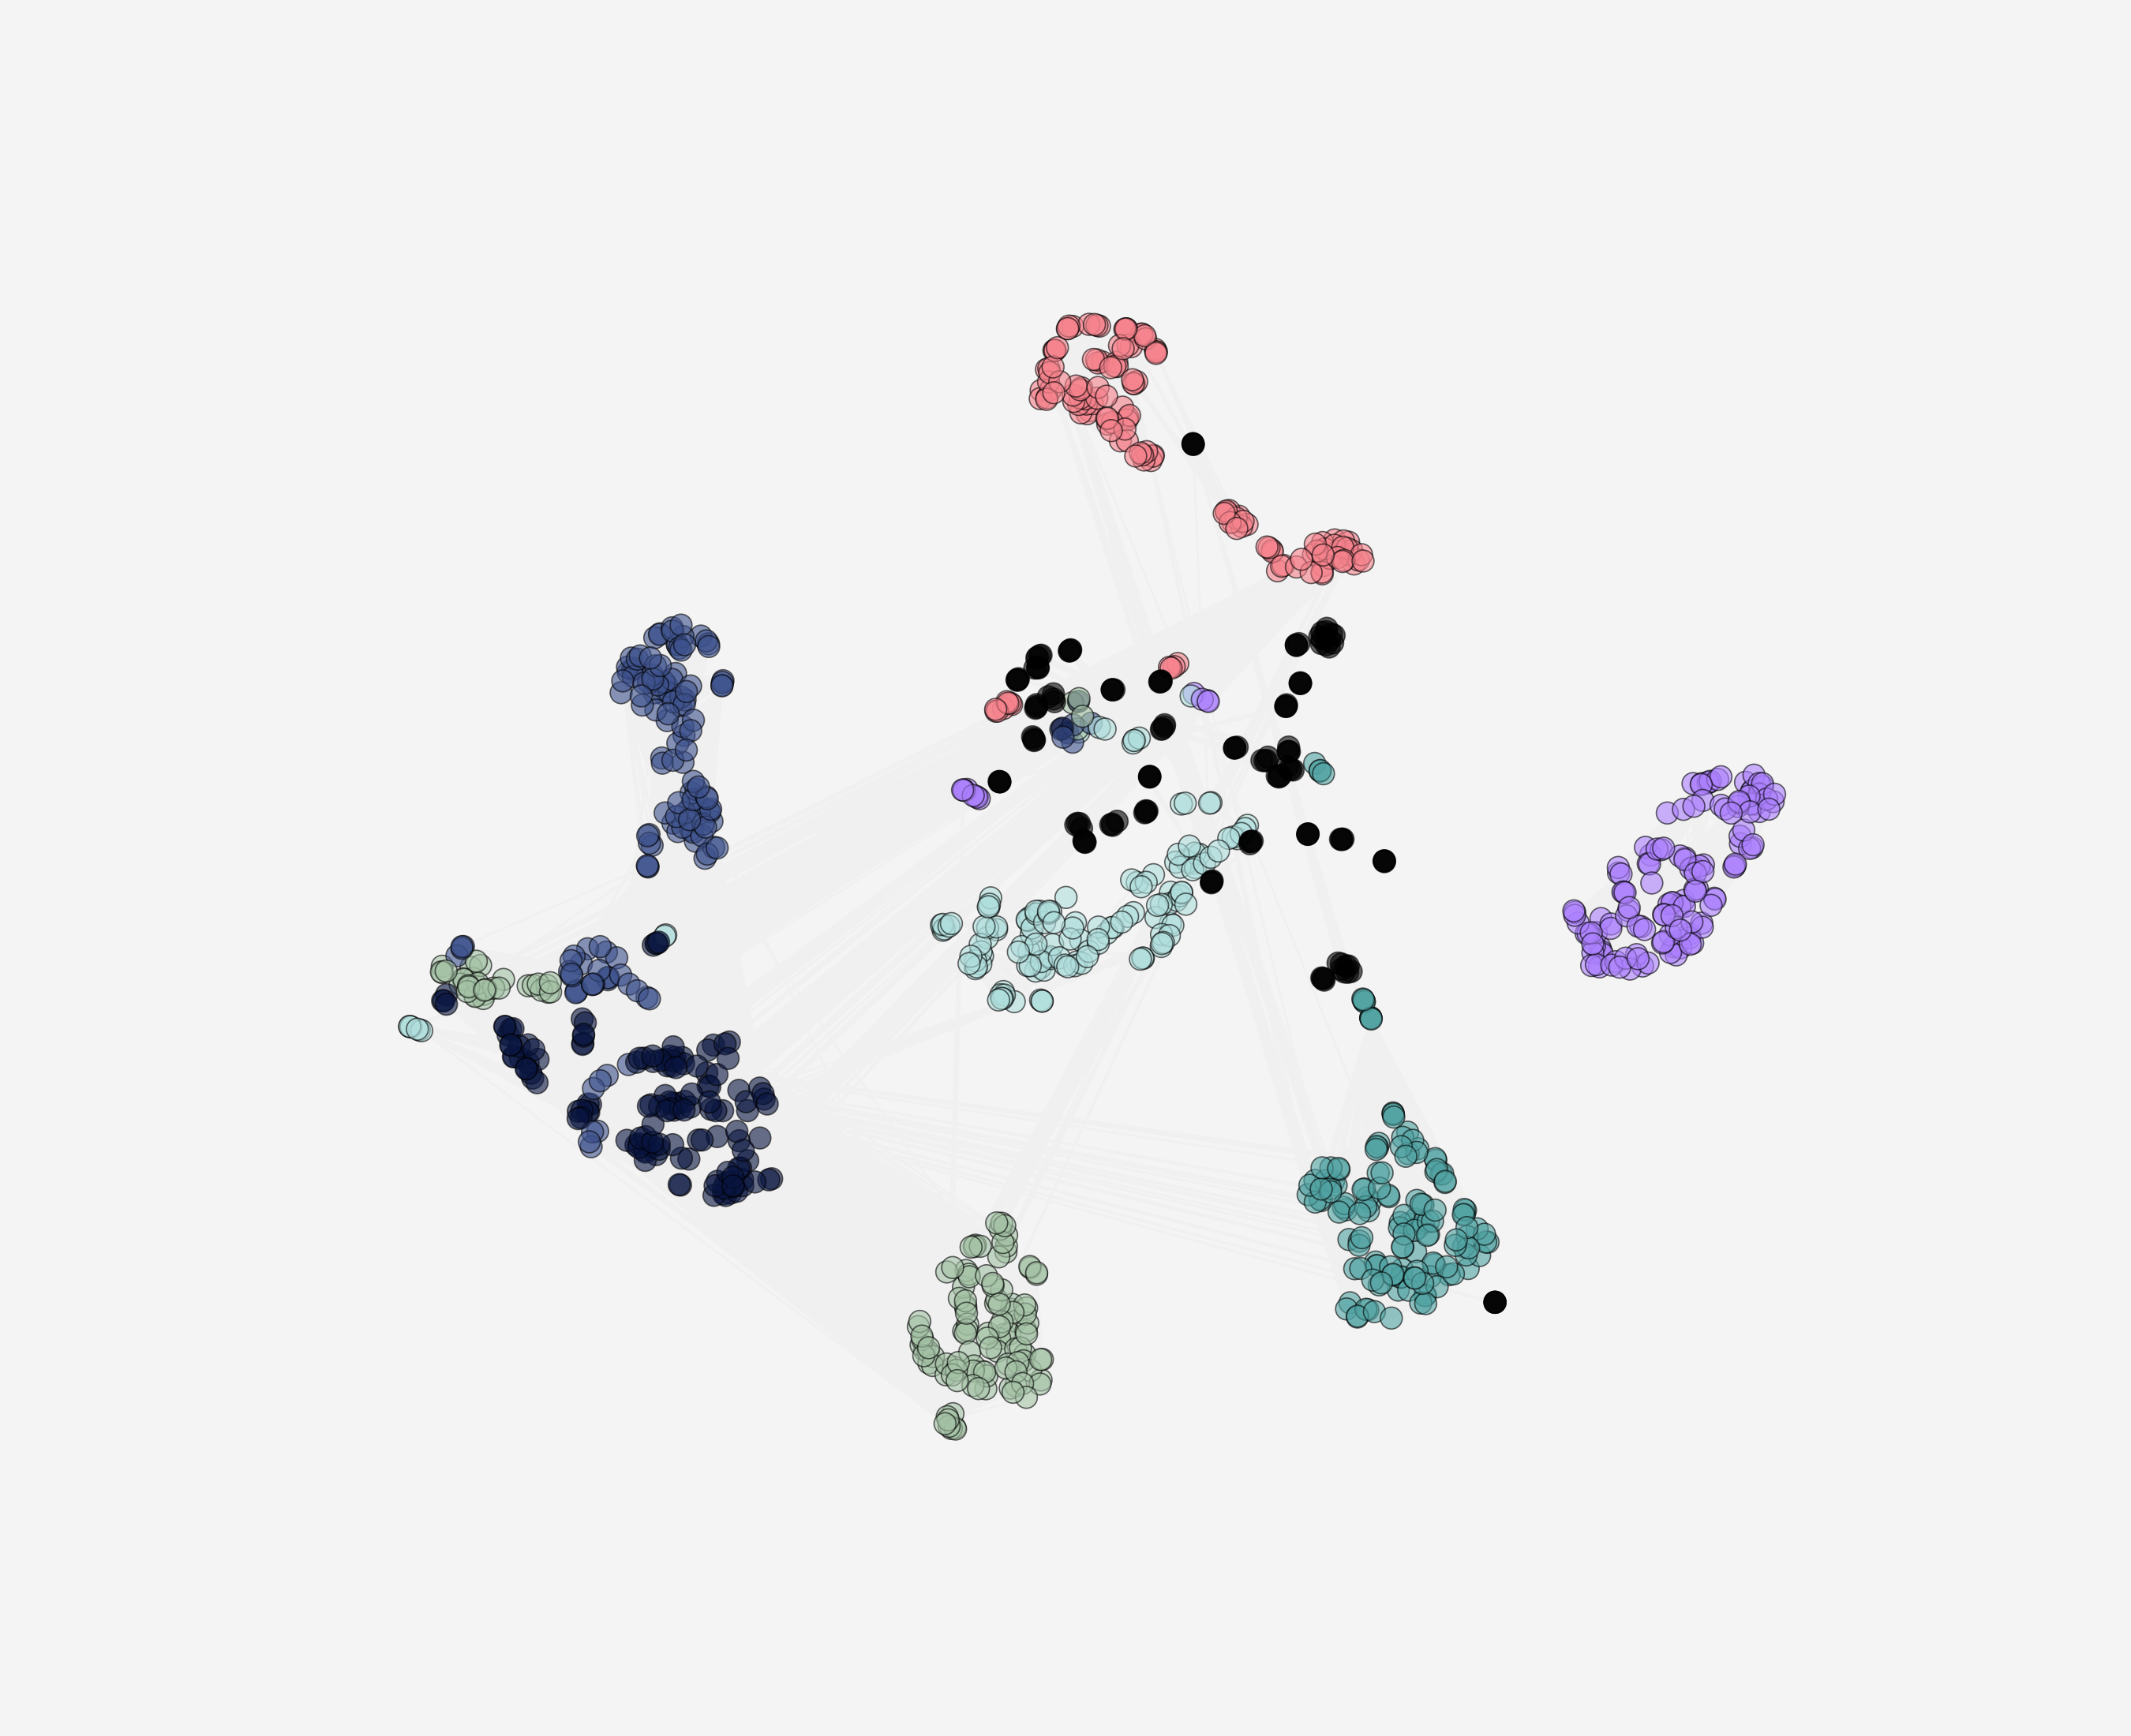

In [353]:
plt.figure(figsize=(13.5,11)) 
nodes = nx.draw_networkx_nodes(G, pos, node_size=size,
            node_color=color, alpha=0.6)
nodes.set_edgecolor('black')
nx.draw_networkx_edges(G, pos, edge_color='#F0F0F0')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = -1, vmax=1))
sm._A = []
plt.axis('off')
plt.grid(False)
plt.savefig('../figures/manuscript_corrNetwork_marker.png', dpi=600, transparent=True)

## Plot by model weights

In [349]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# def colorFader(c1, c2, c3, mix): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
#     c1=np.array(mpl.colors.to_rgb(c1))
#     c2=np.array(mpl.colors.to_rgb(c2))
#     return mpl.colors.to_hex((1-mix)*c1 + mix*c2 + c3)

# c1='#1f77b4' #blue
# c2='green' #green
# c2='white'
# n=500

# colorFader(c1, c2, 0.5)

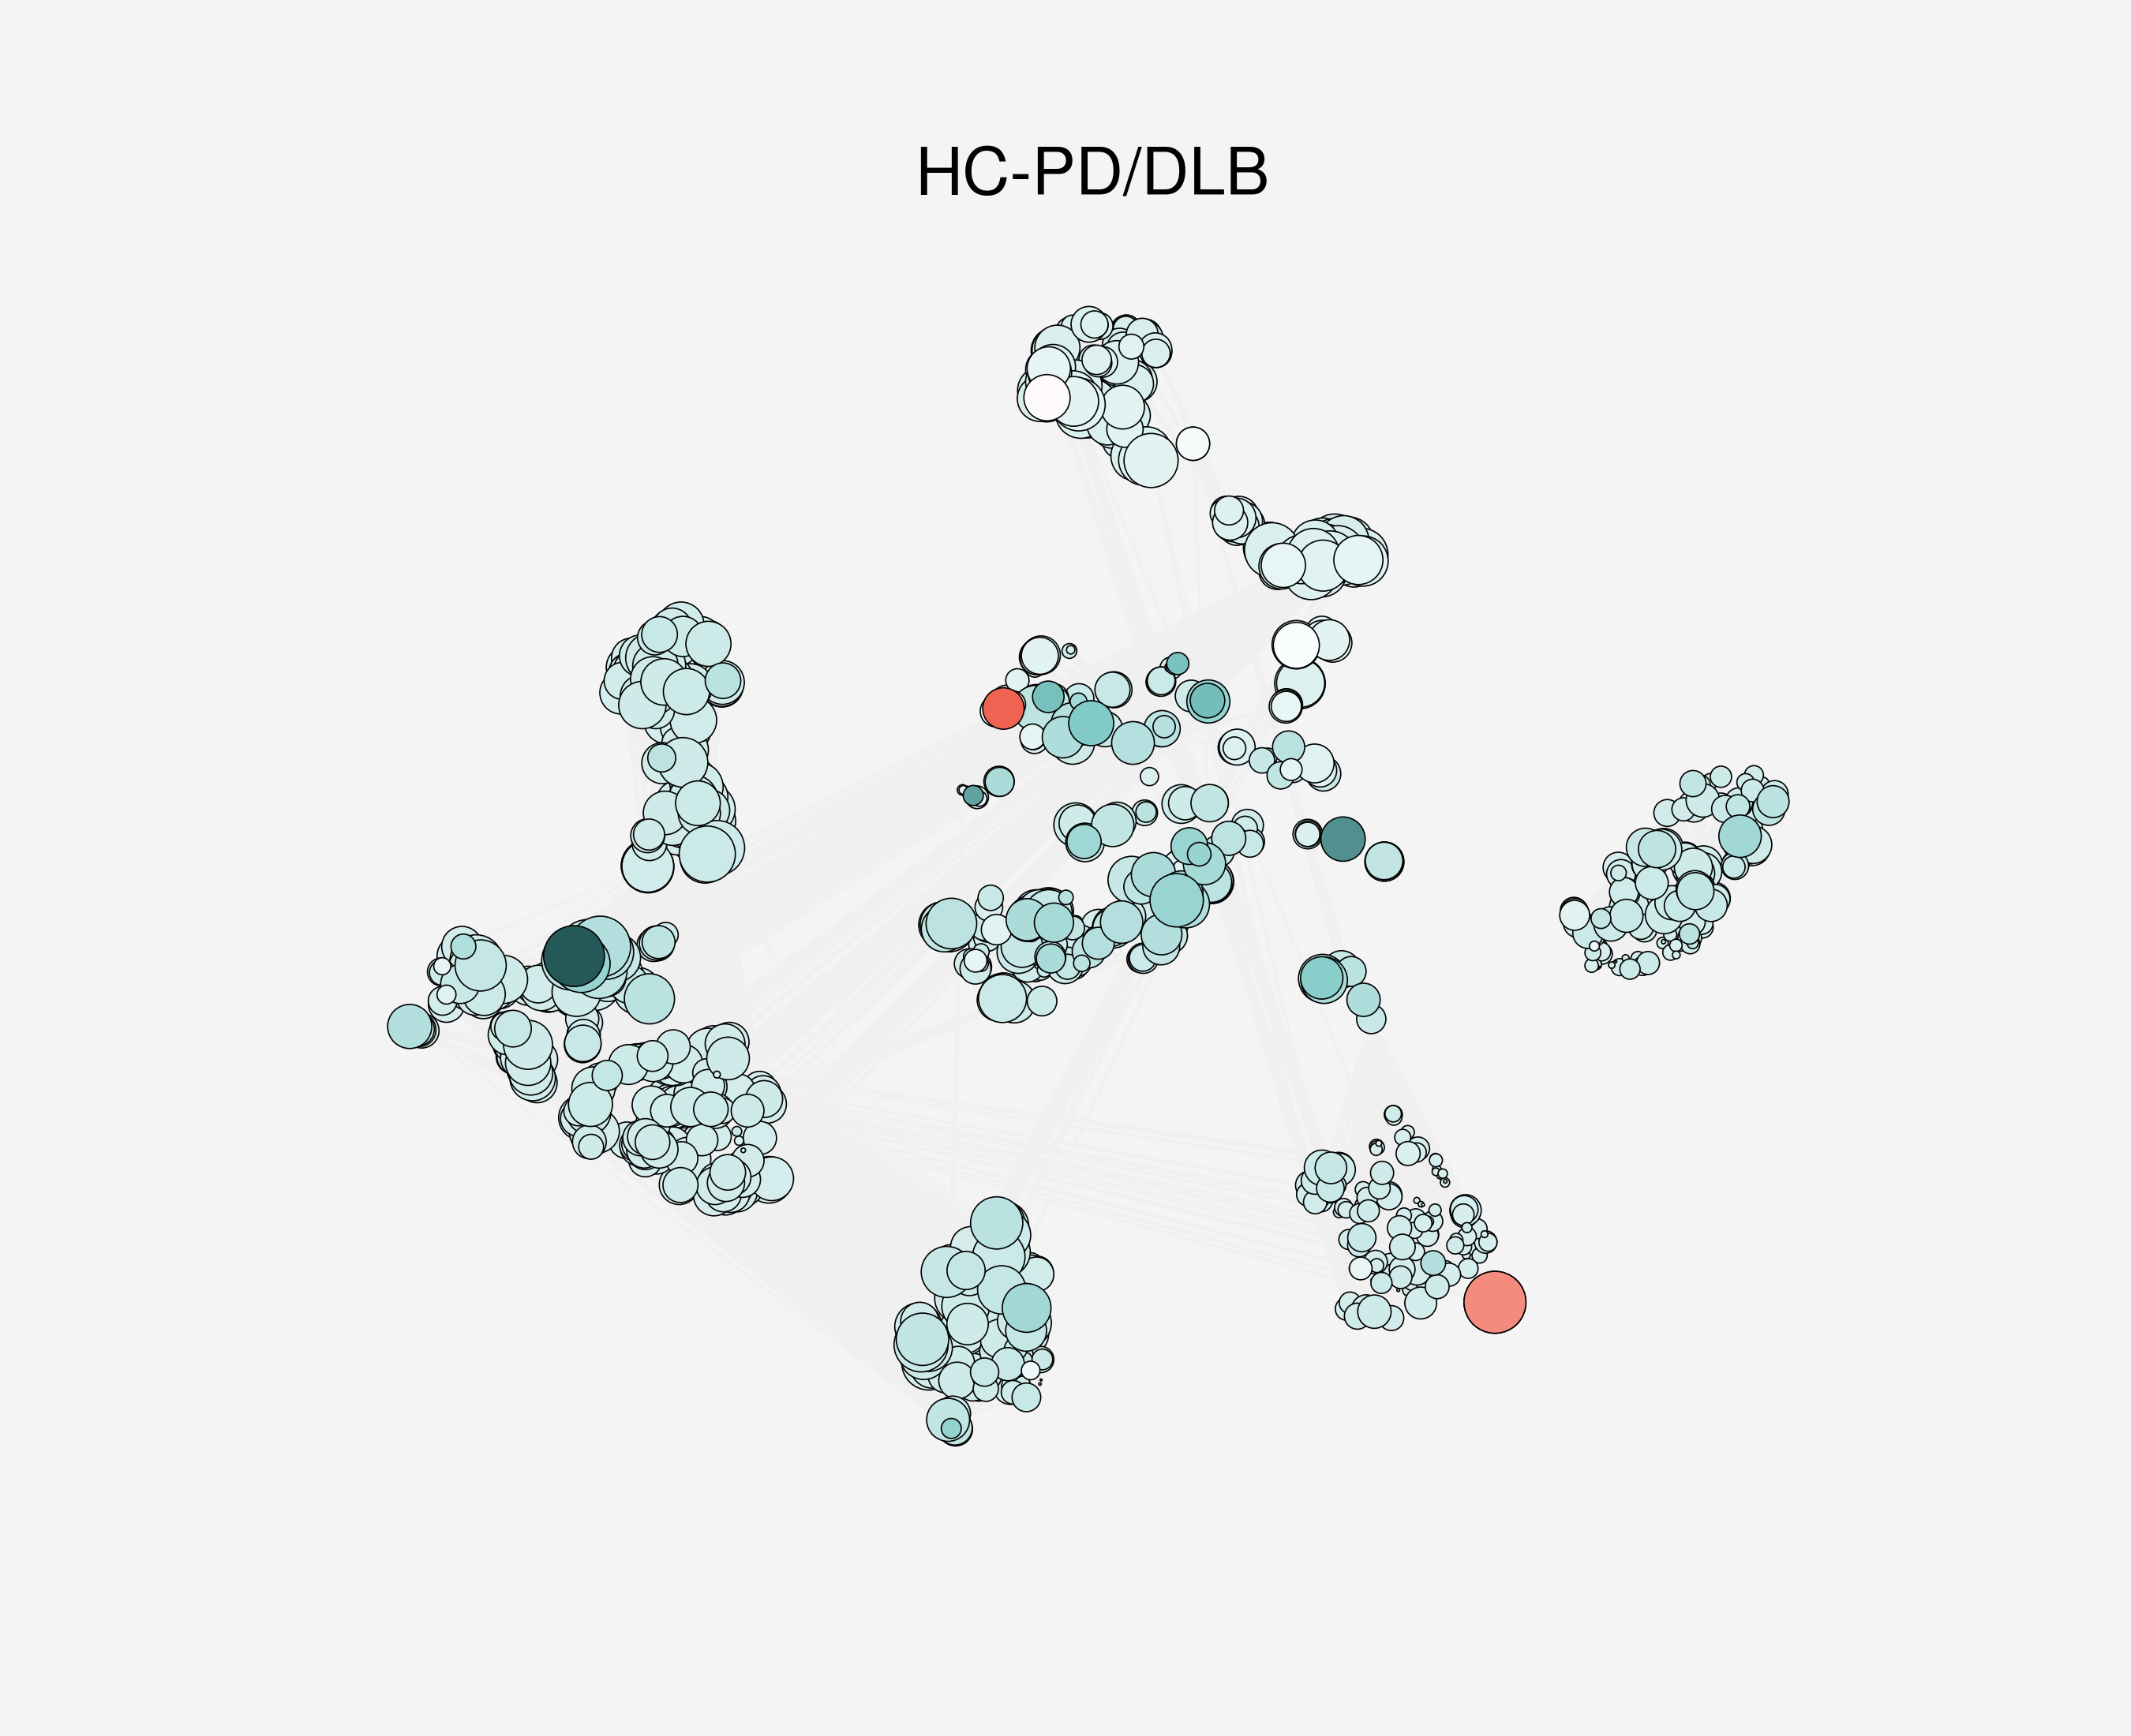

In [350]:
# pairs = [['AD','NDC', 'PD', 'PD_MCIDEM','LBD']]
# pairs = [['HC','AD'], ['HC','NDC', 'PD', 'PD_MCIDEM','LBD'], ['AD','NDC', 'PD', 'PD_MCIDEM','LBD'], ['HC','IDCO']]
# pairs = [['HC','LBD'], ['HC','PD_MCIDEM'], ['HC','PD'], ['AD','LBD'], ['AD','PD_MCIDEM'], ['AD','PD'], ['PD','LBD'], ['PD','PD_MCIDEM'], ['PD_MCIDEM','LBD']]
pairs = [['HC', 'PD', 'PD_MCIDEM','LBD']]#, ['AD', 'PD', 'PD_MCIDEM','LBD']] ['HC','AD'],

for pair in pairs:
    df_pair = df.loc[df.Group.isin(pair), :]
    if pair in [['HC','LBD'], ['HC','PD_MCIDEM'], ['HC','PD'], ['AD','LBD'], ['AD','PD_MCIDEM'], ['AD','PD'], ['PD','LBD'], ['PD','PD_MCIDEM'], ['PD_MCIDEM','LBD']]:
        wt = pd.read_csv('../results/LGBM_wt_NDCGroup.csv')
    else:
        wt = pd.read_csv('../results/LGBM_wt_MainGroup.csv')

    X = df.loc[:, imm_feat].loc[df.Group.isin(pair), :]
    y = df.loc[df.Group.isin(pair), 'Group'].apply(lambda x: 0 if x==pair[0] else 1)
    # drop_indices = get_drop_index(df, pair)
    # X = X.drop(drop_indices)
    # y = y.drop(drop_indices)
    biserial = X.apply(lambda x: pointbiserialr(x, y))
    biserial.index = ['r', 'p']
    biserial.loc['p', :] = biserial.loc['p', :].apply(lambda x: -np.log10(x))
    biserial.columns = cor.columns
    sign = biserial.loc['r', :].apply(lambda x: -1 if x<0 else 1).to_numpy()
    colors = wt.loc[:, '-'.join(pair)] * biserial.loc['r', :].apply(lambda x: -1 if x<0 else 1).to_numpy()
    colors = colors.apply(lambda x: x/np.max(colors))
    colors.index = cor.columns

    # re-sort
    colors = colors[colors.apply(np.abs).sort_values(ascending=True).index]
    xy_wt = pd.DataFrame(xy, index=cor.columns).loc[colors.index, :]
    biserial = biserial.loc[:, colors.index]

    G=nx.Graph()
    for i, nodename in enumerate(colors.index):#range(xy.shape[0]):
        G.add_node(nodename, pos=(xy_wt.iloc[i,0], xy_wt.iloc[i,1]), size=biserial.iloc[0, i], colors=colors.iloc[i])

    for i in range(edge_mat.shape[0]):
        G.add_edge(edge_mat.iloc[i, 0], edge_mat.iloc[i, 1])#, weight=3)

    pos = nx.get_node_attributes(G, 'pos')
    size = 3000*np.abs(list(nx.get_node_attributes(G, 'size').values()))
    color = list(nx.get_node_attributes(G, 'colors').values())


    # plot graph
    norm=plt.Normalize(-1,1)
    # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#482091","#a795c7", "#dcd5e8", "white", "white", "#e3d8c5","#d4be96","#915E00"])
    # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#255957", '#7EC9C6','#D4EDEC', "white", "white", '#FBDEDA', '#F6ACA2', "#EE6352"])
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#255957", '#7EC9C6','#D4EDEC', "white", '#FBDEDA', '#F6ACA2', "#EE6352"])

    # ['#482091', '#915E00', '#99ABF7', '#B2BEB5', '#71797E']

    plt.figure(figsize=(13.5,11)) 
    nodes = nx.draw_networkx_nodes(G, pos, node_size=size,
            node_color=color, alpha=1, cmap=cmap)
    nodes.set_edgecolor('black')
    nx.draw_networkx_edges(G, pos, edge_color='#F0F0F0')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = -1, vmax=1))
    sm._A = []
    # cbar = plt.colorbar(sm)
    # plt.show()
    plt.axis('off')
    plt.grid(False)
    # if ['HC','NDC', 'PD', 'PD_MCIDEM','LBD'] in pairs:
    #     print('iii')
    plt.title('-'.join(pair).replace('HC-PD-PD_MCIDEM-LBD', 'HC-PD/DLB').replace('AD-PD-PD_MCIDEM-LBD', 'AD-PD/DLB'), size=30)
    # else:
        # plt.title('-'.join(pair))
    plt.savefig('../figures/manuscript_corrNetwork_' + '-'.join(pair) + '_wt.png', dpi=600, transparent=True)

In [ ]:
# ('Median (Comp-780_60 YG A-A)', 'pSTAT5').replace('Median (Comp-450_50 Violet I-A)', 'pS6').replace('Median (Comp-515_20 Blue D-A)', 'pSTAT1'))
#     biserial_r['index'] = biserial_r['index'].apply(lambda x: x.replace('Median (Comp-586_15 YG E-A)', 'p38').replace('Median (Comp-610_20 YG D-A)', 'Rab5').replace('Median (Comp-660_20 Red C-A)', 'pPLCg2'))

# Plot heatmap

In [357]:
import pingouin as pg
from pingouin import partial_corr

In [146]:
# pd.DataFrame([partial_corr(data=Xy, x=i, y='Group', covar=['Sex', 'Age'], method='pearson')[['r','p-val']].to_numpy() for i in X.columns])

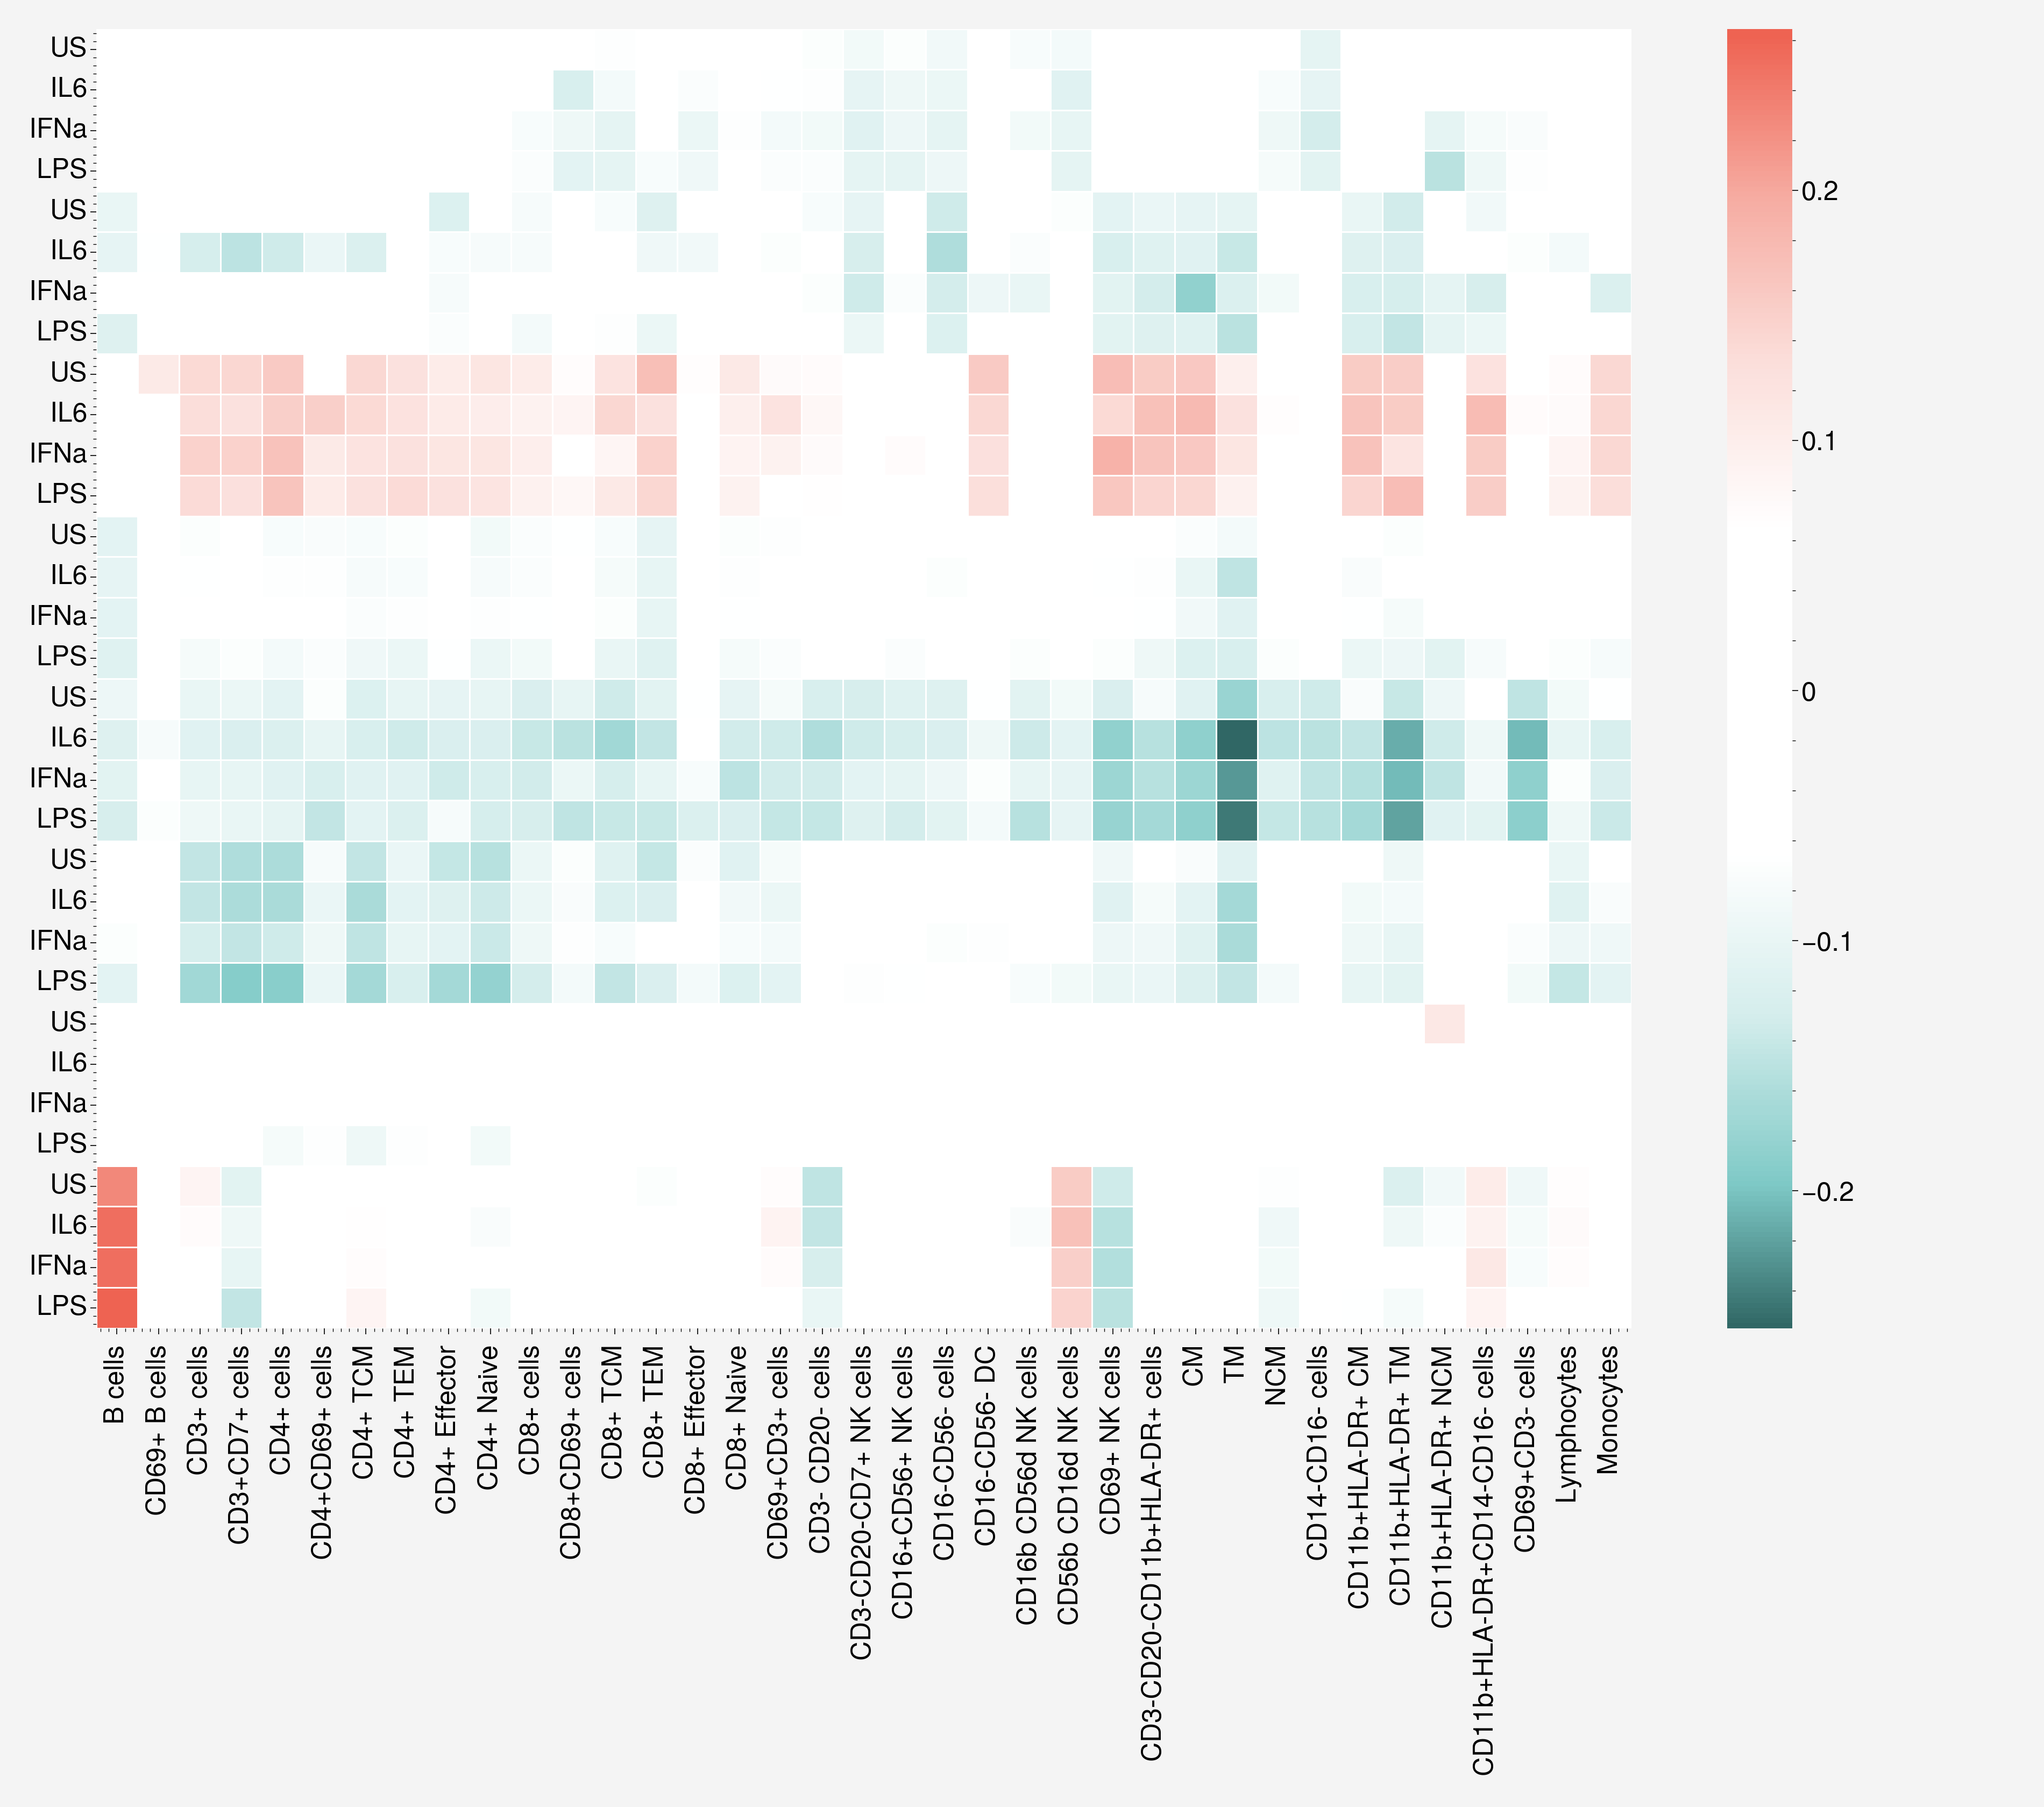

In [360]:
# pairs = [['HC','LBD'], ['HC','PD_MCIDEM'], ['HC','PD'], ['AD','LBD'], ['AD','PD_MCIDEM'], ['AD','PD'], ['PD','LBD'], ['PD','PD_MCIDEM'], ['PD_MCIDEM','LBD']]
pairs = [['HC','AD'], ['HC','NDC', 'PD', 'PD_MCIDEM','LBD'], ['AD','NDC', 'PD', 'PD_MCIDEM','LBD']]

for pair in [['HC','NDC', 'PD', 'PD_MCIDEM','LBD']]:
    df_pair = df.loc[df.Group.isin(pair), :]
    if pair in [['HC','LBD'], ['HC','PD_MCIDEM'], ['HC','PD'], ['AD','LBD'], ['AD','PD_MCIDEM'], ['AD','PD'], ['PD','LBD'], ['PD','PD_MCIDEM'], ['PD_MCIDEM','LBD']]:
        wt = pd.read_csv('../results/LogisticRegression_wt_NDCGroup.csv')
    else:
        wt = pd.read_csv('../results/LogisticRegression_wt_MainGroup.csv')

    X = df.loc[:, imm_feat].loc[df.Group.isin(pair+['IDCO']), :]
    y = df.loc[df.Group.isin(pair+['IDCO']), ['Group', 'Sex', 'Age']]
    y.Group = y.Group.apply(lambda x: 0 if x in ([pair[0], 'IDCO']) else 1)
    y.Sex = y.Sex.apply(lambda x: 0 if x =='M' else 1)
    Xy = pd.concat([X, y], axis=1)
    # y = df.loc[:, 'Sex'].apply(lambda x: 0 if x =='M' else 1)
    # drop_indices = get_drop_index(df, pair)
    # X = X.drop(drop_indices)
    # y = y.drop(drop_indices)
    # biserial = X.apply(lambda x: stats.pointbiserialr(x, y))
    # biserial = pd.DataFrame([partial_corr(data=Xy, x=i, y='Group', covar=['Sex', 'Age'], method='pearson')[['r', 'p-val']].values[0] 
                          # for i in X.columns], index=X.columns, columns=['r', 'p']).transpose()
    biserial = pd.DataFrame([partial_corr(data=Xy, x=i, y='Group', method='pearson')[['r', 'p-val']].values[0] 
                          for i in X.columns], index=X.columns, columns=['r', 'p']).transpose()
    biserial.loc['p', :] = biserial.loc['p', :].apply(lambda x: -np.log10(x))
    biserial.columns = cor.columns
    biserial_r = pd.DataFrame(biserial.iloc[0, :])

    biserial_r = biserial_r.reset_index()
    biserial_r['index'] = biserial_r['index'].apply(lambda x: x.replace('Singlets/Live cells/', '').replace(' of Parent (%)', '').replace('Median (Comp-800_30 Violet A-A)', 'Lamp2'))
    biserial_r['index'] = biserial_r['index'].apply(lambda x: x.replace('Median (Comp-780_60 YG A-A)', 'pSTAT5').replace('Median (Comp-450_50 Violet I-A)', 'pS6').replace('Median (Comp-515_20 Blue D-A)', 'pSTAT1'))
    biserial_r['index'] = biserial_r['index'].apply(lambda x: x.replace('Median (Comp-586_15 YG E-A)', 'p38').replace('Median (Comp-610_20 YG D-A)', 'Rab5').replace('Median (Comp-660_20 Red C-A)', 'pPLCg2'))
    biserial_r['index'] = biserial_r['index'].apply(lambda x: x.replace('B cells/', '').replace('CD3- CD20- cells/CD3-CD20-CD7+ NK cells/', '').replace('CD3- CD20- cells/', ''))
    biserial_r['index'] = biserial_r['index'].apply(lambda x: x.replace('CD3-CD20-CD11b+HLA-DR+cells/', '').replace('CD3+/', '').replace('CD3- CD20- cells/', ''))

    biserial_r['cellType'] = biserial_r['index'].apply(lambda x: x.split('|')[0])
    biserial_r['stim'] = biserial_r['index'].apply(lambda x: x.split('-')[-1])
    biserial_r['signal'] = biserial_r['index'].apply(lambda x: x.split('|')[1].split('-')[0].replace(' ', ''))


    cell_order = \
    ['B cells ', 'CD69+ B cells ',
     'CD3+ ', 
         'CD3+CD7+ cells ', 
         'CD4 ', 
             'CD4/CD4+CD69+ cells ', 'CD4/CM ', 'CD4/EM ', 'CD4/Effector ', 'CD4/Naive ',
         'CD8 ', 
             'CD8/CD8+CD69+ cells ', 'CD8/CM ', 'CD8/EM ', 'CD8/Effector ', 'CD8/Naive ',
         'CD69+ CD3+cells ',
     'CD3- CD20- cells ', 
         'CD3-CD20-CD7+ NK cells ', 
             'CD16+CD56+ NK cells ',
             'CD16-CD56- ',
                 'CD16-CD56-/DC ',
             'CD16b CD56d NK cells ',
             'CD56b CD16d NK cells ',
             'CD69+ NK cells ',
         'CD3-CD20-CD11b+HLA-DR+cells ', 
             'CD14+CD16+ total Monocytes ', 'CD14+CD16- Classical Monocytes ', 'CD14-CD16- cells ', 'CD16+CD14- Non-classical Monocytes ',
         'CD16+ CD14+ TM ', 'CD16+CD14-NCM ', 'CD16-CD14+CD16-  CM ', 'CD16-CD14- ', 'CD69+ CD3-cells ',
     'Lymphocytes ',
     'Monocytes ']

    signals = biserial_r.signal.unique()#['pPLCg2', 'Lamp2']
    biserial_r_sels = []
    for s in signals:
        biserial_r_sel = biserial_r.loc[biserial_r.signal==s, :].drop(['index', 'signal'], axis=1)
        biserial_r_sel = biserial_r_sel.pivot(index='stim', columns='cellType', values='r')
        biserial_r_sel = biserial_r_sel.loc[['US', 'IL6', 'IFNa', 'LPS'], :] 
        biserial_r_sels += [biserial_r_sel]

    biserial_r_sel = pd.concat(biserial_r_sels, axis=0)
    biserial_r_sel = biserial_r_sel.loc[:, cell_order].rename({'CD16-CD14+CD16-  CM ':'CM ', 
                                                               'CD16+CD14-NCM ':'NCM ',
                                                               'CD16+ CD14+ TM ':'TM ',
                                                               'CD8/CM ':'CD8+ TCM ',
                                                               'CD8/EM ':'CD8+ TEM ',
                                                               'CD14-CD16- cells ':'CD11b+HLA-DR+CD14-CD16- cells ',
                                                               'CD8/Effector ':'CD8+ Effector ',
                                                               'CD8/Naive ':'CD8+ Naive ',
                                                               'CD16-CD56-/DC ': 'CD16-CD56- DC ',
                                                               'CD16-CD56- ': 'CD16-CD56- cells ',
                                                               'CD4/CM ':'CD4+ TCM ',
                                                               'CD4/EM ':'CD4+ TEM ',
                                                               'CD4/Effector ':'CD4+ Effector ',
                                                               'CD4/Naive ':'CD4+ Naive ',
                                                               'CD69+ CD3+cells ':'CD69+CD3+ cells ',
                                                               'CD69+ CD3-cells ':'CD69+CD3- cells ',
                                                               'CD16-CD14- ':'CD14-CD16- cells ',
                                                               'CD3-CD20-CD11b+HLA-DR+cells ':'CD3-CD20-CD11b+HLA-DR+ cells ',
                                                               'CD3+ ':'CD3+ cells ',
                                                               'CD4 ':'CD4+ cells ',
                                                               'CD8 ':'CD8+ cells ',
                                                               'CD8/CD8+CD69+ cells ':'CD8+CD69+ cells ',
                                                               'CD4/CD4+CD69+ cells ':'CD4+CD69+ cells ',
                                                               'CD14+CD16+ total Monocytes ':'CD11b+HLA-DR+ TM ',
                                                               'CD14+CD16- Classical Monocytes ':'CD11b+HLA-DR+ CM ',
                                                               'CD16+CD14- Non-classical Monocytes ':'CD11b+HLA-DR+ NCM ',
                                                              }, axis=1)
    rearr = biserial_r_sel.columns.tolist()[:-11] + \
            ['CM ', 'TM ', 'NCM ', 'CD14-CD16- cells '] + \
            ['CD11b+HLA-DR+ CM ', 'CD11b+HLA-DR+ TM ', 'CD11b+HLA-DR+ NCM ', 'CD11b+HLA-DR+CD14-CD16- cells '] +\
            biserial_r_sel.columns.tolist()[-3:]
            
    biserial_r_sel = biserial_r_sel.loc[:, rearr]
    # plt.rcParams.update({'font.size': 7.5})
    plt.figure(figsize=(19, 2.1*len(signals))) 
     
    # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#482091","#a795c7", "#dcd5e8", "#F0F0F0", "#F0F0F0", "#e3d8c5","#d4be96","#915E00"])
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#255957", '#7EC9C6','#D4EDEC', "white", "white", "white", '#FBDEDA', '#F6ACA2', "#EE6352"])
    # cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#255957", '#7EC9C6', "white", "white", '#F6ACA2', "#EE6352"])

    sns.heatmap(biserial_r_sel, center=0, cmap=cmap, linewidths=.5)
    plt.grid(False)
    plt.ylabel('')
    plt.xlabel('')
    plt.tight_layout()
    plt.savefig('../figures/manuscript_heatmap_'+'-'.join(pair)+'_adjustedSexAge.svg', transparent=True)

# Venn diagram

In [369]:
import statsmodels
import mne
from scipy import stats

In [370]:
pairs = [['HC', 'LBD'], ['HC', 'PD_MCIDEM'], ['HC', 'PD']]
all_bi_r = []
all_bi_p = []
aucs= []
for pair in pairs:
    df_pair = df.loc[df.Group.isin(pair), :]
    X = df.loc[:, imm_feat].loc[df.Group.isin(pair), :]
    y = df.loc[df.Group.isin(pair), 'Group'].apply(lambda x: 0 if x in ['HC', 'IDCO', 'AD'] else 1)

    np.random.seed(1)
    drop_indices = get_drop_index(df, pair)
    X = X.drop(drop_indices)
    y = y.drop(drop_indices)
    print(X.shape[0])

    biserial = X.apply(lambda x: stats.pointbiserialr(x, y))
    auc = X.apply(lambda x: roc_auc_score(y, x))
    biserial.index = ['r', 'p']
    biserial.loc['p', :] = biserial.loc['p', :]
    biserial.columns = X.columns
    all_bi_r += [biserial.loc['r', :]]
    all_bi_p += [biserial.loc['p', :]]
    aucs += [auc]

X = df.loc[:, imm_feat]
y = df.loc[:, 'Sex'].apply(lambda x: 0 if x in ['M'] else 1)
biserial = X.apply(lambda x: stats.pointbiserialr(x, y))
biserial.index = ['r', 'p']
biserial.loc['p', :] = biserial.loc['p', :]
biserial.columns = X.columns
all_bi_r += [biserial.loc['r', :]]
all_bi_p += [biserial.loc['p', :]]
aucs += [X.apply(lambda x: roc_auc_score(y, x))]

X = df.loc[:, imm_feat]
y = df.loc[:, 'Age']
biserial = X.apply(lambda x: stats.pearsonr(x, y))
biserial.index = ['r', 'p']
biserial.loc['p', :] = biserial.loc['p', :]
biserial.columns = X.columns
all_bi_r += [biserial.loc['r', :]]
all_bi_p += [biserial.loc['p', :]]
aucs += [X.apply(lambda x: stats.pearsonr(y, x)[0])]

all_bi_p = pd.concat(all_bi_p, axis=1)
all_bi_r = pd.concat(all_bi_r, axis=1)
aucs = pd.concat(aucs, axis=1)

all_bi_p.columns = [i[1] for i in pairs]+['Sex', 'Age']
all_bi_r.columns = [i[1] for i in pairs]+['Sex', 'Age']
aucs.columns = [i[1] for i in pairs]+['Sex', 'Age']

# all_bi_p = all_bi_p.apply(lambda x: mne.stats.fdr_correction(x, alpha=0.05)[1])
# all_bi_p = all_bi_p.loc[all_bi_p.Sex<0.05, :].apply(lambda x: mne.stats.fdr_correction(x, alpha=0.05)[1])
# all_bi_p = all_bi_p * 3 #all_bi_p.shape[0]

170
170
210


In [371]:
all_bi_p_bin= all_bi_p.applymap(lambda x: 1 if x<0.01 else 0)
# all_bi_p_bin= aucs.applymap(lambda x: 1 if x>0.6 else 0)


# Sum of 1s intersected by all three columns
sum_intersect_all_columns = (all_bi_p_bin['LBD'] & all_bi_p_bin['PD_MCIDEM'] & all_bi_p_bin['PD']).sum()

# Sum of 1s intersected between each pair of columns
sum_intersect_column1_column2 = (all_bi_p_bin['LBD'] & all_bi_p_bin['PD_MCIDEM']).sum() - sum_intersect_all_columns
sum_intersect_column1_column3 = (all_bi_p_bin['LBD'] & all_bi_p_bin['PD']).sum() - sum_intersect_all_columns
sum_intersect_column2_column3 = (all_bi_p_bin['PD_MCIDEM'] & all_bi_p_bin['PD']).sum() - sum_intersect_all_columns

# Sum of 1s unique to each column
sum_unique_column1 = all_bi_p_bin['LBD'].sum() - sum_intersect_all_columns - sum_intersect_column1_column2 - sum_intersect_column1_column3
sum_unique_column2 = all_bi_p_bin['PD_MCIDEM'].sum() - sum_intersect_all_columns - sum_intersect_column2_column3 - sum_intersect_column1_column2
sum_unique_column3 = all_bi_p_bin['PD'].sum() - sum_intersect_all_columns - sum_intersect_column2_column3 - sum_intersect_column1_column3

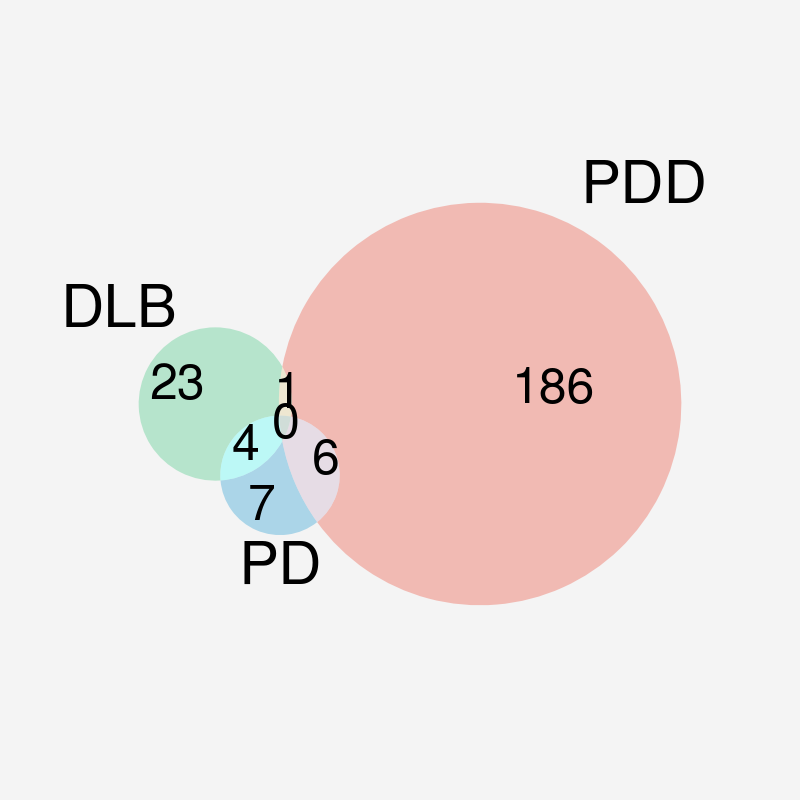

In [372]:
# library
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
colors = ['#255957', "#EE6352", '#3FA7D6', "#FAC05E", "#59CD90"]
# Use the venn2 function
venn3(subsets = (sum_unique_column1, sum_unique_column2, sum_intersect_column1_column2, 
                 sum_unique_column3, sum_intersect_column1_column3, sum_intersect_column2_column3, 
                 sum_intersect_all_columns), set_labels = ('DLB', 'PDD', 'PD'), 
                  set_colors=[colors[4], colors[1], colors[2]])
plt.savefig('../figures/manuscript_heatmap_venn.svg', transparent=True)
plt.show()

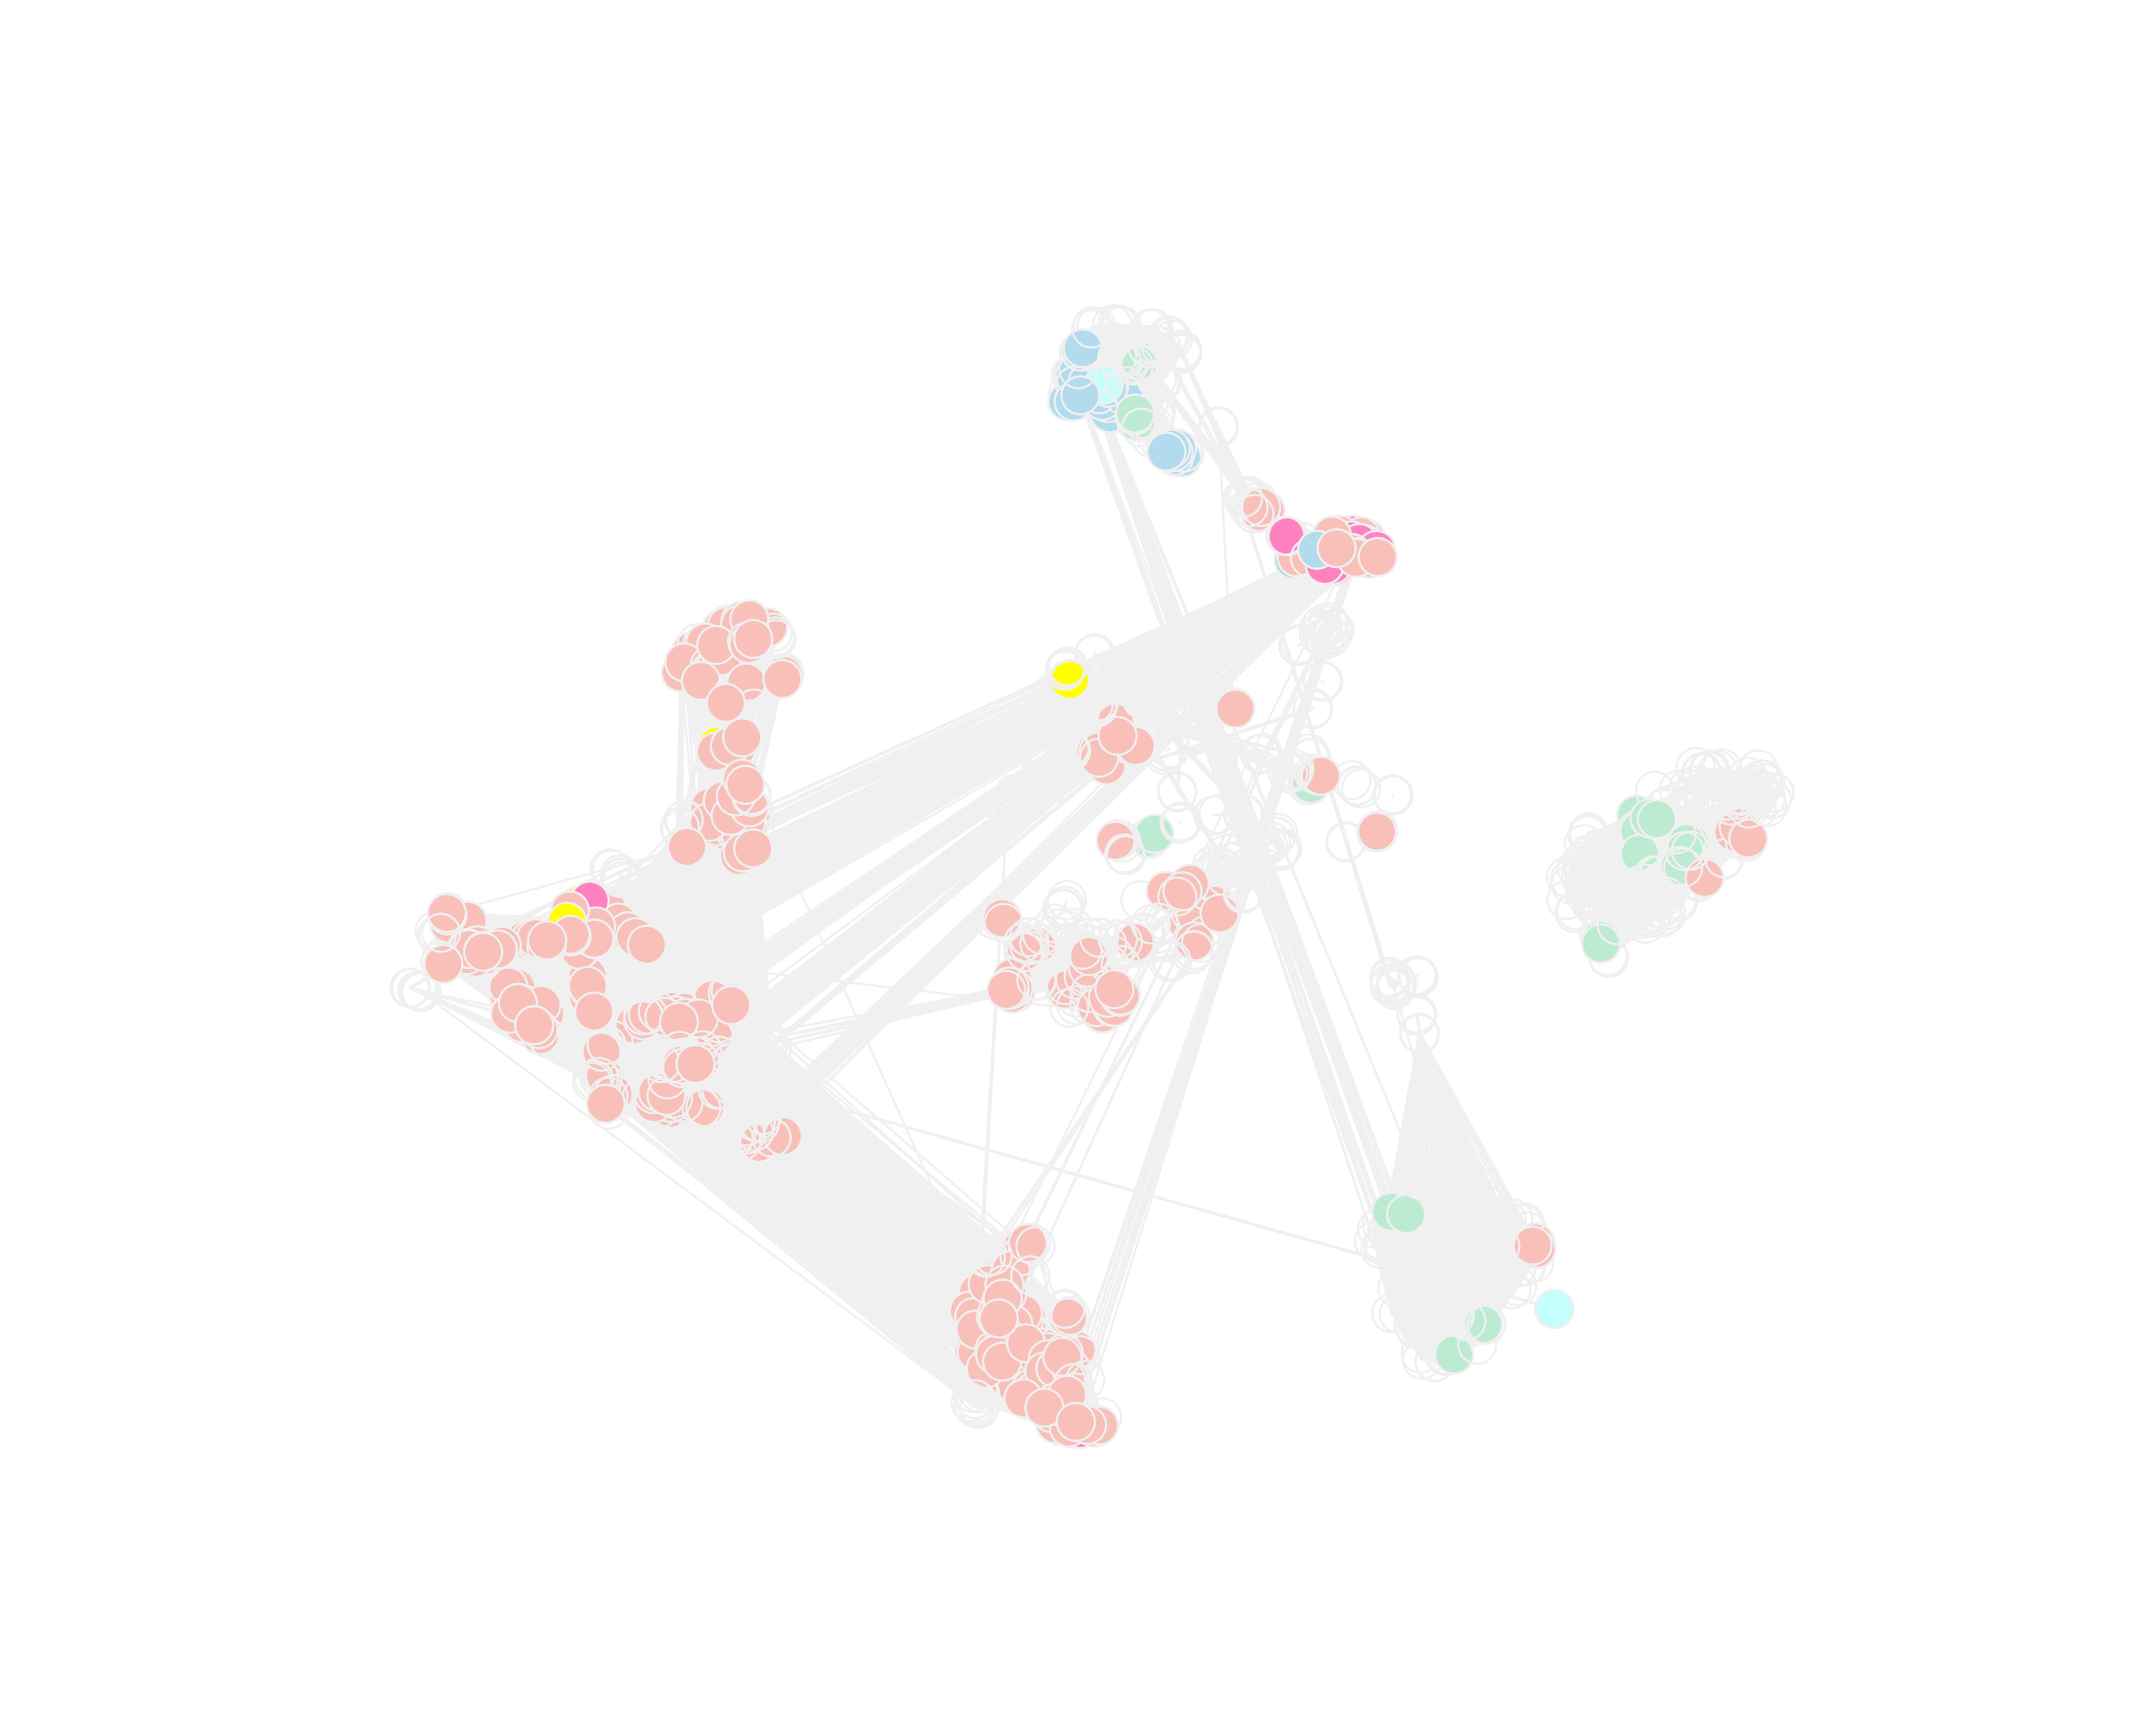

In [139]:
all_bi_p_bin_noSexAge = all_bi_p_bin.drop(['Sex', 'Age'], axis=1)
colors = all_bi_p_bin_noSexAge.apply(lambda x: 'black' if x.sum()==3 else 
                            '#c3fffd' if ((x.LBD==1) & (x.PD==1)) else 
                            # '#f4eed8' if ((x.LBD==1) & (x.PD_MCIDEM==1)) else
                            'yellow' if ((x.LBD==1) & (x.PD_MCIDEM==1)) else
                            # '#ede3eb' if ((x.PD==1) & (x.PD_MCIDEM==1)) else
                            'pink' if ((x.PD==1) & (x.PD_MCIDEM==1)) else
                            '#b2dbee' if x.PD==1 else '#f8c0b9' if x.PD_MCIDEM==1 else '#bcebd2' if x.LBD==1 else
                             'white',
                            axis=1)

alphas = colors.apply(lambda x: 0 if x == 'white' else 1)

G=nx.Graph()
for i, nodename in enumerate(colors.index):#range(xy.shape[0]):
    G.add_node(nodename, pos=(xy[i,0], xy[i,1]), size=1, colors=colors.iloc[i])

for i in range(edge_mat.shape[0]):
    G.add_edge(edge_mat.iloc[i, 0], edge_mat.iloc[i, 1])#, weight=3)

pos = nx.get_node_attributes(G, 'pos')
size = 300*np.abs(list(nx.get_node_attributes(G, 'size').values()))
color = list(nx.get_node_attributes(G, 'colors').values())


plt.figure(figsize=(13.5,11)) 
nodes = nx.draw_networkx_nodes(G, pos, node_size=size,
        node_color=color, alpha=alphas.values)
nodes.set_edgecolor('#F0F0F0')
nx.draw_networkx_edges(G, pos, edge_color='#F0F0F0')
plt.axis('off')
plt.grid(False)
plt.savefig('../figures/manuscript_corrNetwork_venn.png', dpi=600, transparent=True)

# Meta data prediction

In [384]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from lightgbm import LGBMRegressor
from sklearn.feature_selection import f_regression, SelectKBest
from scipy.stats import pearsonr

In [385]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification  # You can replace this with your dataset
from sklearn.ensemble import RandomForestClassifier 
from scipy.stats import mannwhitneyu, ttest_ind
n_iters = 10
import warnings
warnings.filterwarnings("ignore")

In [386]:
rp = []
def pred_neuro(test, df, n_iters):
    X = df.loc[~df[test].isna(), [i for i in df.columns if 'Singlets' in i]]
    y = df.loc[~df[test].isna(), test]
    for i in range(n_iters):
        model = LGBMRegressor(n_estimators=500, n_jobs=-1)
        # model = linear_model.LogisticRegression()
        k_best = SelectKBest(score_func=f_classif, k=200)
        pipeline = make_pipeline(k_best, model)
        cv = KFold(n_splits=10, shuffle=True, random_state=42)
        pred = cross_val_predict(pipeline, X, y, cv=4)
        r = pearsonr(y, pred)
        return r

rp += [(Parallel(n_jobs=len(tests))(delayed(pred_neuro)(test, df, n_iters) for test in tests))]

/home/tpjoe/miniconda3/envs/main/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/tpjoe/miniconda3/envs/main/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/tpjoe/miniconda3/envs/main/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyar

In [387]:
p = [rp_[1] for rp_ in rp[0]]
r = [rp_[0] for rp_ in rp[0]]

In [388]:
rp = pd.DataFrame([r, p], columns=tests, index=['r', 'p']).transpose().sort_values('r')
rp['color'] = rp.apply(lambda x: 'P<0.05 & R>0' if ((x.p<0.05) & (x.r>0)) else 'P>0.05 | R<0', axis=1)

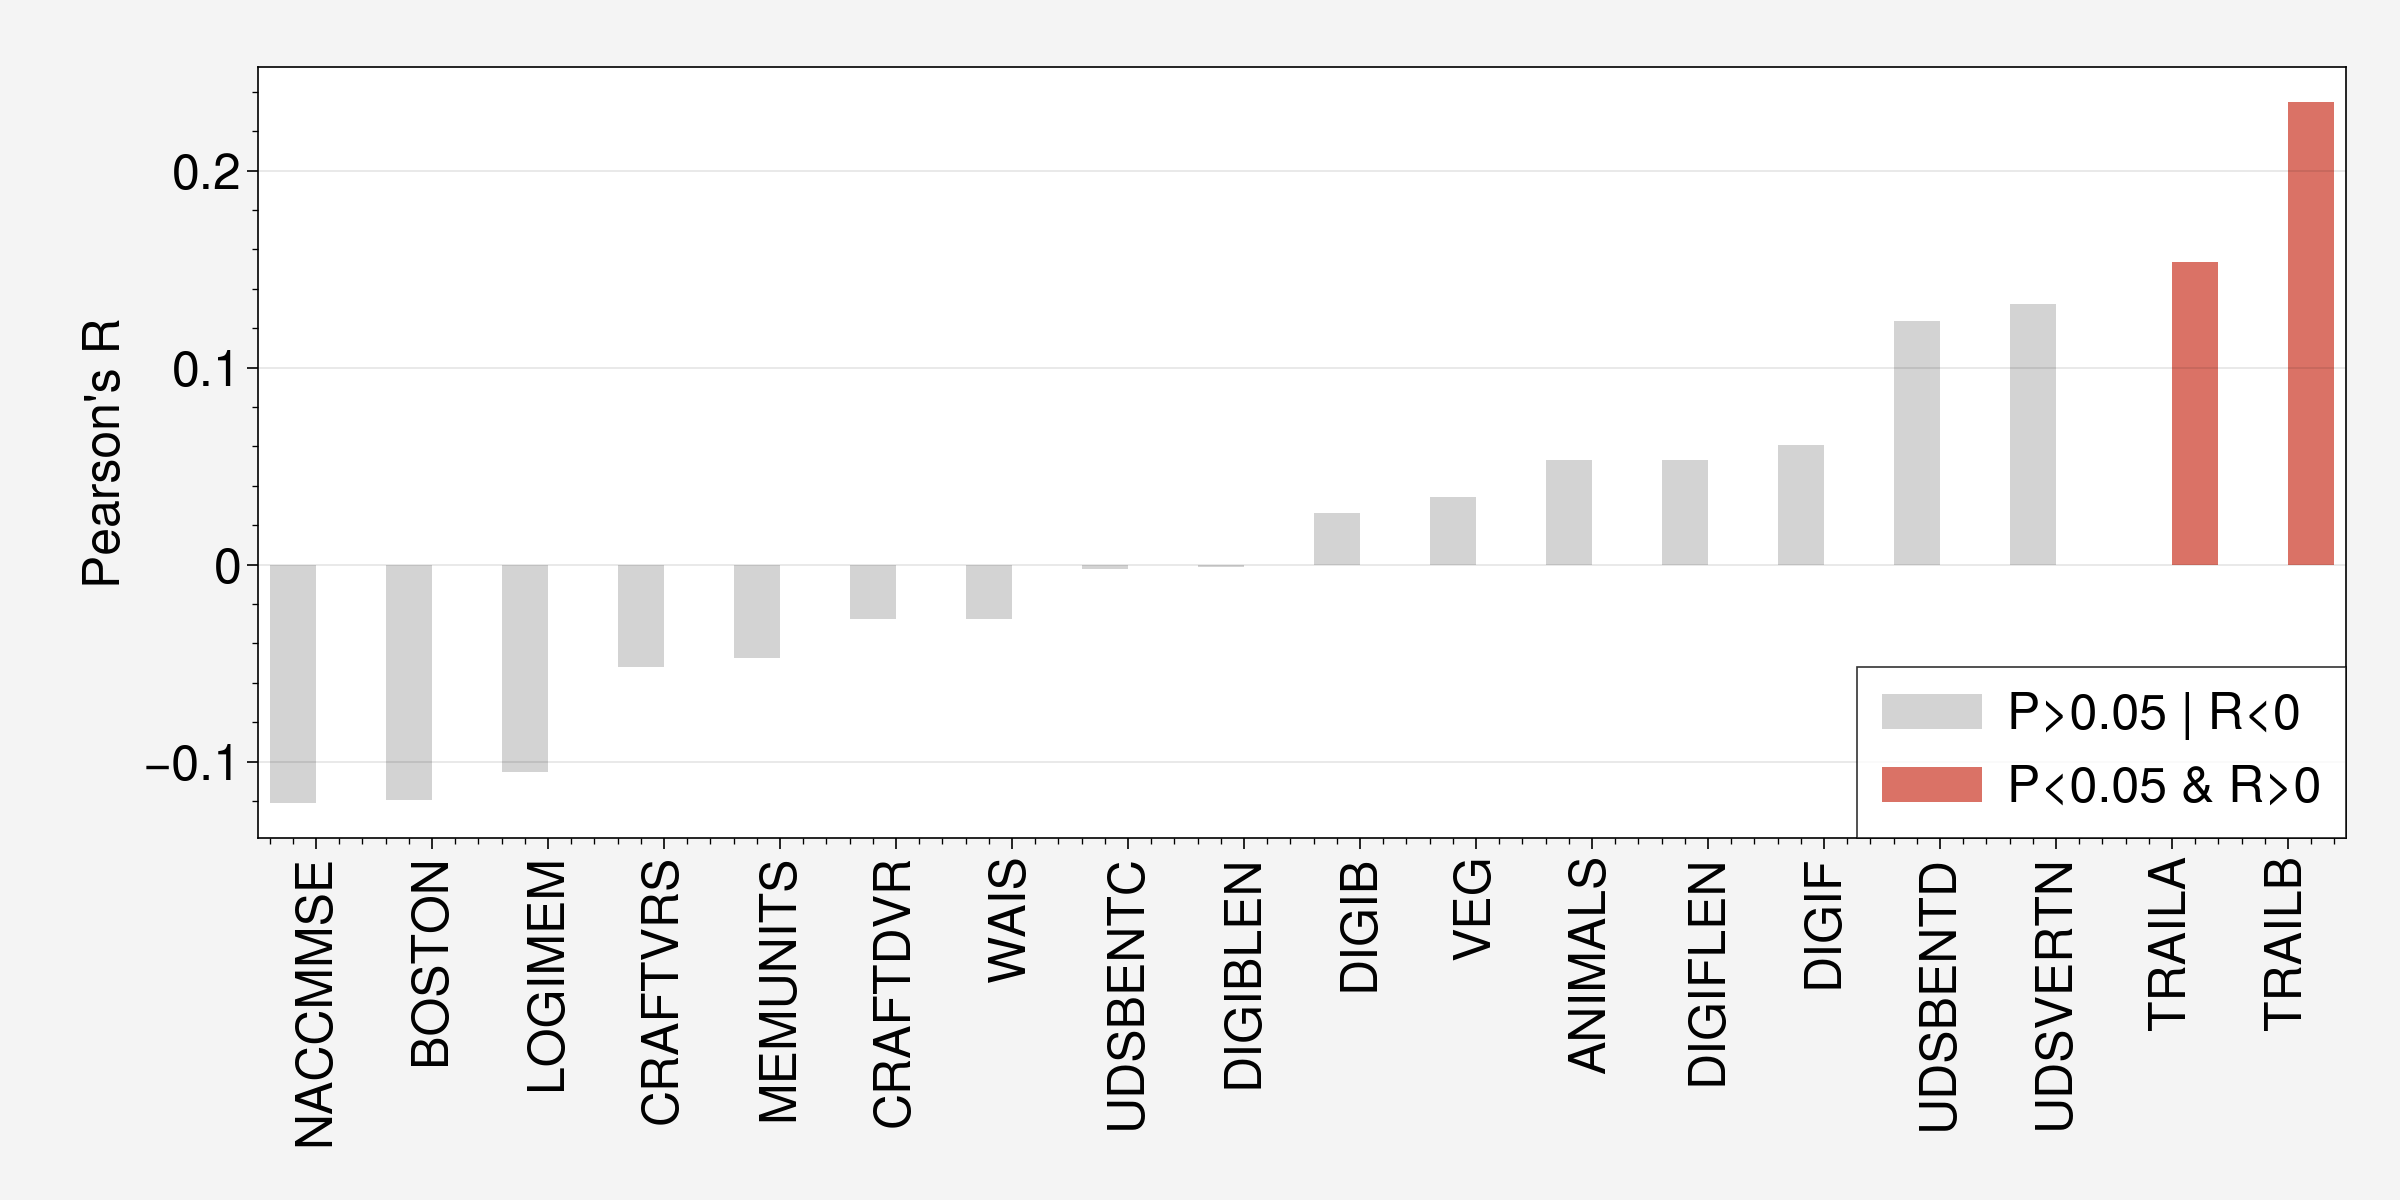

In [389]:
fig, ax = plt.subplots(1, figsize=(12,6))
# fig, ax = plt.subplots(1, figsize=(12/3,5/3))
g = sns.barplot(data=rp.reset_index(), x='index', y='r', ax=ax, hue='color', palette=['lightgray', colors[1]])
# auc.mean(axis=1).sort_values().plot.bar()

plt.xticks(rotation=90)
plt.ylabel("Pearson's R")
plt.xlabel("")
g.legend_.set_title(None)
plt.tight_layout()
plt.savefig('../figures/manuscript_neuropsych.png', dpi=600, transparent=True)

In [380]:
def get_aucs(X, y):
    X = X.to_numpy().reshape(-1,1)
    model = LGBMClassifier(n_jobs=-1, class_weight='balanced', n_estimators =500, learning_rate=0.06)
    # pipeline = make_pipeline(k_best, model)
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    pred = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]#, random_state=10)
    return roc_auc_score(y, pred)

all_bi_r = []
all_bi_p = []
aucs = []
pair = ['HC', 'LBD', 'PD_MCIDEM', 'PD']
df_pair = df.loc[df.Group.isin(pair), :]
X = df.loc[:, imm_feat].loc[df.Group.isin(pair), :]
y = df.loc[df.Group.isin(pair), 'Group'].apply(lambda x: 0 if x in ['HC', 'IDCO', 'AD'] else 1)

np.random.seed(1)
drop_indices = get_drop_index(df, pair)
X = X.drop(drop_indices)
y = y.drop(drop_indices)
print(X.shape[0])

biserial = X.apply(lambda x: stats.pointbiserialr(x, y))
biserial.index = ['r', 'p']
biserial.loc['p', :] = biserial.loc['p', :]
biserial.columns = X.columns
all_bi_r += [biserial.loc['r', :]]
all_bi_p += [biserial.loc['p', :]]
# aucs += [X.apply(lambda x: roc_auc_score(y, x))]
aucs += [pd.Series(Parallel(n_jobs=10)(delayed(get_aucs)(X[x], y) for x in X.columns), index=X.columns)]


for comor in ['REMDIS', 'HYPERTEN']:
    df_pair = df.loc[~df[comor].isna(), :]
    drop_index = get_drop_index(df_pair, pair=[0, 1], col=comor)
    df_pair = df_pair.drop(drop_index, axis=0)
    X = df_pair.loc[:, imm_feat]
    y = df_pair.loc[:, [comor]+['Sex', 'Age']]
    y.Sex = y.Sex.apply(lambda x: 0 if x=='M' else 0)
    y[comor] = y[comor].astype(int).apply(lambda x: 0 if x==0 else 1)
    Xy = pd.concat([X, y], axis=1)
    
    biserial = pd.DataFrame([partial_corr(data=Xy, x=i, y=comor, covar=['Sex', 'Age'], method='pearson')[['r', 'p-val']].values[0] 
                          for i in X.columns], index=X.columns, columns=['r', 'p']).transpose() #X.apply(lambda x: stats.pointbiserialr(x, y))
    # biserial.index = ['r', 'p']
    biserial.loc['p', :] = biserial.loc['p', :]
    biserial.columns = X.columns
    all_bi_r += [biserial.loc['r', :]]
    all_bi_p += [biserial.loc['p', :]]
    # aucs += [pd.Series(Parallel(n_jobs=100)(delayed(get_aucs)(X[x], y) for x in X.columns), index=X.columns)]
    aucs += [pd.Series( [roc_auc_score(y[comor].values, X[i].values) for i in X.columns], index=X.columns )]

X = df.loc[:, imm_feat]
y = df.loc[:, 'Sex'].apply(lambda x: 0 if x in ['M'] else 1)
biserial = X.apply(lambda x: stats.pointbiserialr(x, y))
biserial.index = ['r', 'p']
biserial.loc['p', :] = biserial.loc['p', :]
biserial.columns = X.columns
all_bi_r += [biserial.loc['r', :]]
all_bi_p += [biserial.loc['p', :]]
aucs += [pd.Series(Parallel(n_jobs=10)(delayed(get_aucs)(X[x], y) for x in X.columns), index=X.columns)]

X = df.loc[:, imm_feat]
y = df.loc[:, 'Age']
biserial = X.apply(lambda x: pearsonr(x, y))
biserial.index = ['r', 'p']
biserial.loc['p', :] = biserial.loc['p', :]
biserial.columns = X.columns
all_bi_r += [biserial.loc['r', :]]
all_bi_p += [biserial.loc['p', :]]
aucs += [X.apply(lambda x: pearsonr(y, x)[0])]

all_bi_p = pd.concat(all_bi_p, axis=1)
all_bi_r = pd.concat(all_bi_r, axis=1)
aucs = pd.concat(aucs, axis=1)
all_bi_p.columns = ['PD/DLB', 'REMDIS', 'HYPERTEN', 'Sex', 'Age']
all_bi_r.columns = ['PD/DLB', 'REMDIS', 'HYPERTEN', 'Sex', 'Age']
aucs.columns = ['PD/DLB', 'REMDIS', 'HYPERTEN', 'Sex', 'Age']

251


/home/tpjoe/miniconda3/envs/main/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/tpjoe/miniconda3/envs/main/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/tpjoe/miniconda3/envs/main/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyar

In [381]:
from statsmodels.stats.multitest import multipletests

# all_bi_p = all_bi_p.apply(lambda x: multipletests(x, alpha=0.05, method='fdr_bh')[1])
# all_bi_p_bin= all_bi_p.applymap(lambda x: 1 if x<0.05 else 0)
all_bi_p_bin= aucs.applymap(lambda x: 1 if x>0.6 else 0)
# all_bi_p_bin.loc[all_bi_p_bin.Sex<0.05, ['LBD', 'PD', 'PD_MCIDEM']] = 0
# all_bi_p_bin.loc[all_bi_p_bin.Age<0.05, ['LBD', 'PD', 'PD_MCIDEM']] = 0

dis1 = 'REMDIS'
dis2 = 'HYPERTEN'
# Sum of 1s intersected by all three columns
sum_intersect_all_columns = (all_bi_p_bin['PD/DLB'] & all_bi_p_bin[dis1] & all_bi_p_bin[dis2]).sum()

# Sum of 1s intersected between each pair of columns
sum_intersect_column1_column2 = (all_bi_p_bin['PD/DLB'] & all_bi_p_bin[dis1]).sum() - sum_intersect_all_columns
sum_intersect_column1_column3 = (all_bi_p_bin['PD/DLB'] & all_bi_p_bin[dis2]).sum() - sum_intersect_all_columns
sum_intersect_column2_column3 = (all_bi_p_bin[dis1] & all_bi_p_bin[dis2]).sum() - sum_intersect_all_columns

# Sum of 1s unique to each column
sum_unique_column1 = all_bi_p_bin['PD/DLB'].sum() - sum_intersect_all_columns - sum_intersect_column1_column2 - sum_intersect_column1_column3
sum_unique_column2 = all_bi_p_bin[dis1].sum() - sum_intersect_all_columns - sum_intersect_column2_column3 - sum_intersect_column1_column2
sum_unique_column3 = all_bi_p_bin[dis2].sum() - sum_intersect_all_columns - sum_intersect_column2_column3 - sum_intersect_column1_column3

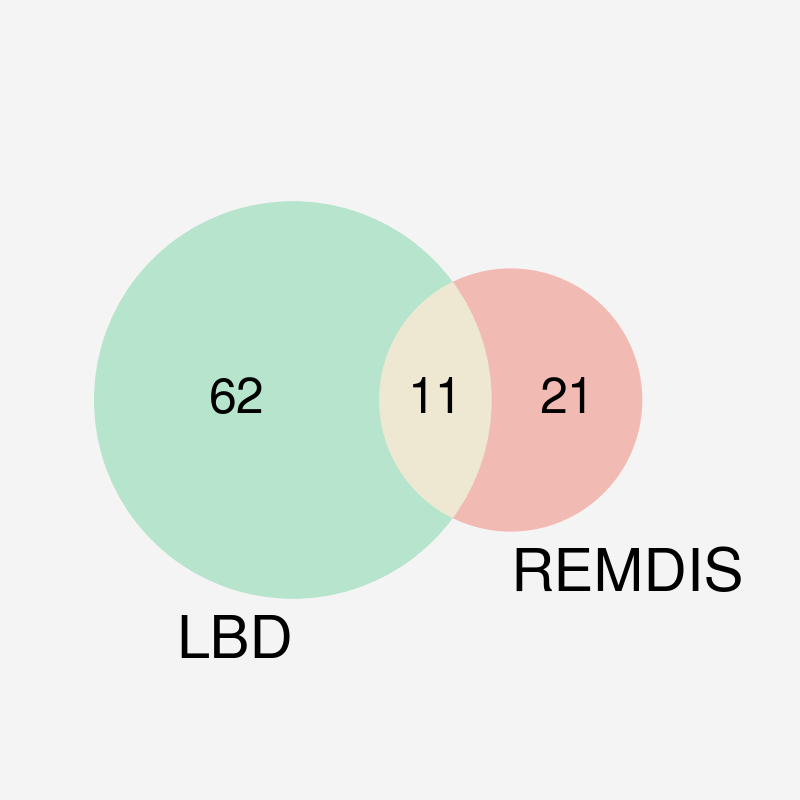

In [382]:
# library
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
colors = ['#255957', "#EE6352", '#3FA7D6', "#FAC05E", "#59CD90"]
# Use the venn2 function
# venn3(subsets = (sum_unique_column1, sum_unique_column2, sum_intersect_column1_column2, 
#                  sum_unique_column3, sum_intersect_column1_column3, sum_intersect_column2_column3, 
#                  sum_intersect_all_columns), set_labels = ('LBD', dis1, dis2), 
#                   set_colors=[colors[4], colors[1], colors[2]])
venn2(subsets = (sum_unique_column1, sum_unique_column2, sum_intersect_column1_column2), 
      set_labels = ('LBD', dis1), 
                  set_colors=[colors[4], colors[1]])
plt.tight_layout()
plt.savefig('../figures/manuscript_heatmap_venn_comorbid_new.svg', transparent=True)

In [392]:
# factors = [i for i in updrs if i not in ['PARKSIGN', 'RESTTRL', 'RESTTRR', 'PARKGAIT', 'TRESTFAC']]
factors = updrs[9:-1]

def pred_comor(test, df, n_iters):
    p = []
    auc = []
    preds = []
    y_true = []
    # drop_index = get_drop_index(df, pair=[0, 1], col=test)
    # df = df.drop(drop_index, axis=0)
    X = df.loc[(df.Group.isin(['PD', 'PD_MCIDEM', 'LBD'])) & (~df[test].isna()), [i for i in df.columns if 'Singlets' in i]]
    y = df.loc[(df.Group.isin(['PD', 'PD_MCIDEM', 'LBD'])) & (~df[test].isna()), test].clip(upper=1)
    for i in range(n_iters):
        model = LGBMClassifier(n_jobs=-1, class_weight='balanced', n_estimators =500, learning_rate=0.06)
        # model = linear_model.LogisticRegression()
        k_best = SelectKBest(score_func=f_classif, k=1184)
        pipeline = make_pipeline(k_best, model)
        # cv = KFold(n_splits=10, shuffle=True, random_state=1)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42+i*2)
        pred = cross_val_predict(pipeline, X, y, cv=cv, method='predict_proba')[:, 1]#, random_state=10)
        preds += list(pred)
        y_true += y.to_list()
        p += [mannwhitneyu(pred[y==1], pred[y==0])]
        auc += [roc_auc_score(y, pred)]
        # r = ttest_ind(pred[y==1], pred[y==0])
    return p, auc, preds, y_true

rp_auc = Parallel(n_jobs=len(comorbid_binary))(delayed(pred_comor)(c, df, 3) for c in factors)
rp = [i[0] for i in rp_auc]
rp = pd.DataFrame([[np.mean([i[0] for i in r]) for r in rp], 
                   [np.mean([i[1] for i in r]) for r in rp]], index=['r', 'p'], columns=factors).transpose()
auc = pd.DataFrame([i[1] for i in rp_auc], index=factors)
preds = [i[2] for i in rp_auc]
y_true = [i[3] for i in rp_auc]

/home/tpjoe/miniconda3/envs/main/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/tpjoe/miniconda3/envs/main/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/home/tpjoe/miniconda3/envs/main/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyar

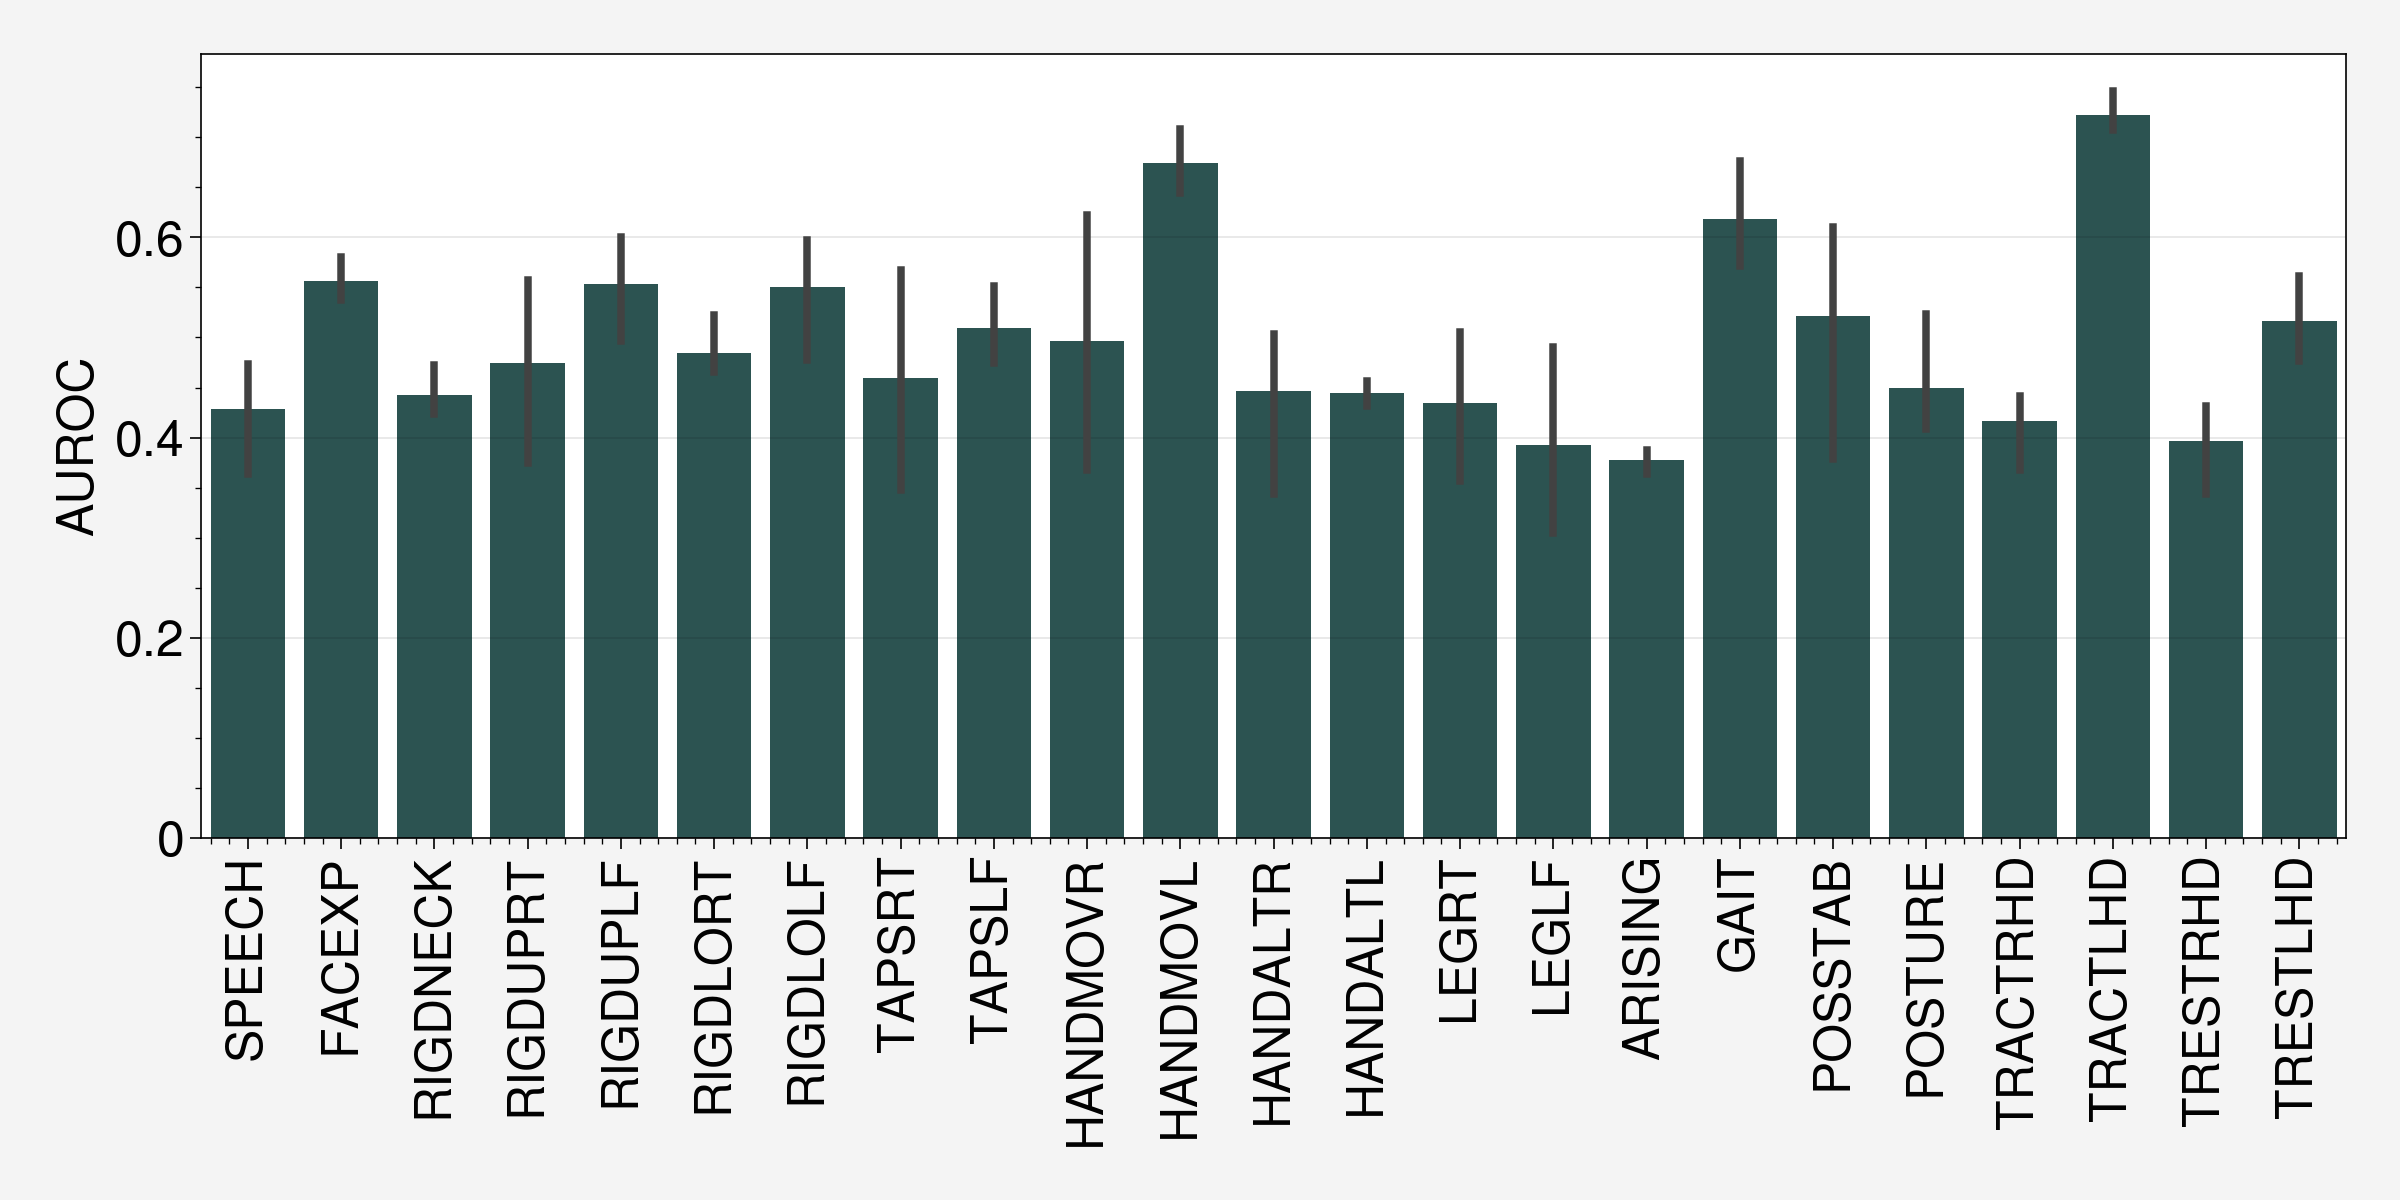

In [394]:
fig, ax = plt.subplots(1, figsize=(12,6))
# fig, ax = plt.subplots(1, figsize=(12/3,5/3))
g = sns.barplot(data=auc.reset_index().melt('index'), x='index', y='value', ax=ax, palette=[colors[0]])
# auc.mean(axis=1).sort_values().plot.bar()

plt.xticks(rotation=90)
plt.ylabel("AUROC")
plt.xlabel("")
plt.tight_layout()
plt.savefig('../figures/manuscript_updrs.png', dpi=600, transparent=True)